In [2]:
pip install paddlepaddle-gpu==2.6.2 -f https://www.paddlepaddle.org.cn/whl/mkl/avx/stable.html


Looking in links: https://www.paddlepaddle.org.cn/whl/mkl/avx/stable.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.0/759.0 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/AIP491/Training/PaddleOCR

/content/drive/.shortcut-targets-by-id/1t74jmV7PvXPifc2SYrjAP0A2Ztqq26VA/AIP491/Training/PaddleOCR


In [4]:
!pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.5 MB/s eta 0:00:00


In [ ]:
!python tools/export_model.py -c /content/drive/MyDrive/AIP491/Training/PaddleOCR/config.yml -o Global.pretrained_model="/content/drive/MyDrive/AIP491/Training/PaddleOCR/output/train_15_3/best_model.pdparams" Global.save_inference_dir="./inference/det_db_inference/"

[2025/04/19 13:25:06] ppocr WARNING: Skipping import of the encryption module.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-69064512a6ad>", line 1, in <cell line: 0>
    get_ipython().system('python tools/export_model.py -c /content/drive/MyDrive/AIP491/Training/PaddleOCR/config.yml -o Global.pretrained_model="/content/drive/MyDrive/AIP491/Training/PaddleOCR/output/train_15_3/best_model.pdparams" Global.save_inference_dir="./inference/det_db_inference/"')
  File "/usr/local/lib/python3.11/dist-packages/google/colab/_shell.py", line 123, in system
    output = _system_commands._system_compat(self, *args, **kwargs)  # pylint:disable=protected-access
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/colab/_system_commands.py", line 454, in _system_compat
    result = _run_command(
             ^^^^^^^^^^^^^
  File "/usr/lo

TypeError: object of type 'NoneType' has no len()

In [ ]:
import os
import subprocess

# Tạo thư mục lưu kết quả nếu chưa có
os.makedirs("./inference/det_result/", exist_ok=True)

# Lệnh chạy infer_det
command = [
    "python", "tools/infer_det.py",
    "-c", "/content/drive/MyDrive/AIP491/Training/PaddleOCR/config.yml",
    "-o",
    'Global.pretrained_model="/content/drive/MyDrive/AIP491/Training/PaddleOCR/output/train_15_3/latest"',
    'Global.infer_img="/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/det/val_set"'
]

# Đường dẫn file log
log_file_path = "/content/drive/MyDrive/AIP491/Training/PaddleOCR/inference/det_result/det_predict_log.txt"

# Chạy lệnh và ghi log ra file
with open(log_file_path, "w") as log_file:
    subprocess.run(command, stdout=log_file, stderr=log_file)


In [ ]:
!pip install shapely tqdm


In [ ]:
import os
import sys
import cv2
import json
import numpy as np
from tqdm import tqdm

# Thêm PaddleOCR vào path
sys.path.append("/content/drive/MyDrive/AIP491/Training/PaddleOCR")

# Import PaddleOCR modules
from tools.program import load_config as get_config
from ppocr.data import create_operators, transform
from ppocr.postprocess import build_post_process
from ppocr.modeling.architectures import build_model
from ppocr.utils.save_load import load_model
import paddle

# --- Config ---
label_path = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/det/Label_predict_val.txt"
image_root = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/det/val_set"
config_path = "/content/drive/MyDrive/AIP491/Training/PaddleOCR/config.yml"
pretrained_model = "/content/drive/MyDrive/AIP491/Training/PaddleOCR/output/train_15_3/latest"
fail_vis_dir = "./inference/det_result/fail_vis"
os.makedirs(fail_vis_dir, exist_ok=True)

# --- Load ground truth ---
gt_dict = {}
with open(label_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) != 2:
            continue
        img_path, ann = parts
        gt_dict[img_path] = json.loads(ann)

# --- Load model ---
cfg = get_config(config_path)
cfg["Global"]["pretrained_model"] = pretrained_model
cfg["Global"]["infer_img"] = image_root

# Tạo các bước xử lý và model
ops = create_operators(cfg["Eval"]["dataset"]["transforms"], cfg["Global"])
post_process_class = build_post_process(cfg["PostProcess"], cfg["Global"])
model = build_model(cfg["Architecture"])
load_model(cfg, model, model_type='det')
model.eval()

# --- Hàm tính IoU ---
def polygon_iou(p1, p2):
    from shapely.geometry import Polygon
    try:
        poly1 = Polygon(p1).convex_hull
        poly2 = Polygon(p2).convex_hull
        if not poly1.is_valid or not poly2.is_valid:
            return 0
        inter = poly1.intersection(poly2).area
        union = poly1.union(poly2).area
        return inter / union if union != 0 else 0
    except:
        return 0

# --- Hàm predict ---
def predict_det(img_path):
    with open(img_path, 'rb') as f:
        img_bytes = f.read()
    data = {'image': img_bytes}
    data = transform(data, ops)
    img_tensor = paddle.to_tensor(data['image'][None, ...])
    with paddle.no_grad():
        pred = model(img_tensor)
        post_result = post_process_class(pred, [data['shape']])
    return post_result[0]['points']


# --- Evaluate ---
fail_cases = []
for img_rel_path, gt_boxes in tqdm(gt_dict.items(), desc="Evaluating"):
    img_path = os.path.join(image_root, os.path.basename(img_rel_path))
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    pred_boxes = predict_det(img_path)

    matched = [False] * len(gt_boxes)
    for pb in pred_boxes:
        for idx, gt in enumerate(gt_boxes):
            iou = polygon_iou(pb, gt["points"])
            if iou > 0.5:
                matched[idx] = True
                break

    # Nếu có ít hơn 50% box đúng → fail case
    if sum(matched) / max(1, len(gt_boxes)) < 0.5:
        fail_cases.append(img_rel_path)

        # Vẽ ảnh và lưu
        for box in pred_boxes:
            box = np.array(box, dtype=np.int32)
            cv2.polylines(img, [box], isClosed=True, color=(0, 0, 255), thickness=2)  # predict: đỏ
        for gt in gt_boxes:
            box = np.array(gt["points"], dtype=np.int32)
            cv2.polylines(img, [box], isClosed=True, color=(0, 255, 0), thickness=2)  # GT: xanh
        cv2.imwrite(os.path.join(fail_vis_dir, os.path.basename(img_rel_path)), img)

# --- Ghi danh sách ảnh fail ---
fail_txt_path = "./inference/det_result/fail_cases.txt"
with open(fail_txt_path, "w") as f:
    for item in fail_cases:
        f.write(item + "\n")

print(f"\n📉 Tổng số ảnh fail: {len(fail_cases)}")
print("📄 Đã lưu danh sách tại:", fail_txt_path)
print("🖼️ Ảnh fail có vẽ box lưu tại:", fail_vis_dir)


REC


In [ ]:
!python tools/export_model.py -c /content/drive/MyDrive/AIP491/Training/PaddleOCR/config_rec.yml -o Global.pretrained_model="/content/drive/MyDrive/AIP491/Training/PaddleOCR/result_train_rec_newdata/output/v3_en_mobile/latest"  Global.save_inference_dir="./inference/en_PP-OCRv3_rec/"

[2025/04/20 03:31:39] ppocr WARNING: Skipping import of the encryption module.
W0420 03:32:34.523936  1540 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.8
W0420 03:32:34.542752  1540 gpu_resources.cc:164] device: 0, cuDNN Version: 9.2.
[2025/04/20 03:32:49] ppocr INFO: load pretrain successful from /content/drive/MyDrive/AIP491/Training/PaddleOCR/result_train_rec_newdata/output/v3_en_mobile/latest
[2025/04/20 03:32:49] ppocr INFO: Export inference config file to ./inference/en_PP-OCRv3_rec/inference.yml
Skipping import of the encryption module
I0420 03:32:55.173252  1540 program_interpreter.cc:212] New Executor is Running.
[2025/04/20 03:32:56] ppocr INFO: inference model is saved to ./inference/en_PP-OCRv3_rec/inference


In [ ]:
import os
os.makedirs("./inference/det_result/", exist_ok=True)
!python tools/infer_det.py \
  -c /content/drive/MyDrive/AIP491/Training/PaddleOCR/config.yml \
  -o Global.pretrained_model="/content/drive/MyDrive/AIP491/Training/PaddleOCR/result_train_rec_newdata/output/v3_en_mobile/latest" \
     Global.infer_img="/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/val_set" \
> /content/drive/MyDrive/AIP491/Training/PaddleOCR/inference/det_result/rec_predict_log_2004.txt

W0420 03:34:08.613350  2242 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.8
W0420 03:34:08.622575  2242 gpu_resources.cc:164] device: 0, cuDNN Version: 9.2.


In [ ]:
!python tools/infer_rec.py \
  -c /content/drive/MyDrive/AIP491/Training/PaddleOCR/config_rec.yml \
  -o Global.pretrained_model="/content/drive/MyDrive/AIP491/Training/PaddleOCR/result_train_rec_newdata/output/v3_en_mobile/latest" \
     Global.infer_img="/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/val_set" \
> /content/drive/MyDrive/AIP491/Training/PaddleOCR/inference/rec_result/rec_predict_log_2004.txt




W0420 03:37:15.871416  4539 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.8
W0420 03:37:15.872604  4539 gpu_resources.cc:164] device: 0, cuDNN Version: 9.2.


In [ ]:
!python tools/export_model.py \
  -c /content/drive/MyDrive/AIP491/Training/PaddleOCR/config_rec.yml \
  -o Global.pretrained_model="/content/drive/MyDrive/AIP491/Training/PaddleOCR/output/last_rec/latest" \
     Global.character_dict_path="/content/drive/MyDrive/AIP491/Training/PaddleOCR/dict/plate_dict.txt" \
     Global.save_inference_dir="./inference/en_PP-OCRv3_rec/"


[2025/04/03 09:32:22] ppocr WARNING: Skipping import of the encryption module.
W0403 09:32:25.055599 20407 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.8
W0403 09:32:25.056478 20407 gpu_resources.cc:164] device: 0, cuDNN Version: 9.2.
[2025/04/03 09:32:25] ppocr WARNING: The shape of model params head.ctc_head.fc.weight [64, 40] not matched with loaded params head.ctc_head.fc.weight [64, 97] !
[2025/04/03 09:32:25] ppocr WARNING: The shape of model params head.ctc_head.fc.bias [40] not matched with loaded params head.ctc_head.fc.bias [97] !
[2025/04/03 09:32:25] ppocr WARNING: The shape of model params head.sar_head.decoder.embedding.weight [42, 512] not matched with loaded params head.sar_head.decoder.embedding.weight [99, 512] !
[2025/04/03 09:32:25] ppocr WARNING: The shape of model params head.sar_head.decoder.prediction.weight [1536, 41] not matched with loaded params head.sar_head.decoder.prediction.w

In [ ]:
from paddleocr import PaddleOCR
import os

# Cấu hình
rec_model_dir = '/content/drive/MyDrive/AIP491/Training/PaddleOCR/result_train_rec_newdata/inference/en_PP-OCRv3_rec'
input_folder = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/val_set'
output_folder = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/results'
os.makedirs(output_folder, exist_ok=True)

# Khởi tạo model chỉ dùng nhận dạng
ocr = PaddleOCR(use_angle_cls=False, lang='en', det=False, rec=True, rec_model_dir=rec_model_dir)

# Duyệt qua từng ảnh trong thư mục
for file_name in os.listdir(input_folder):
    if file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(input_folder, file_name)
        result = ocr.ocr(img_path, cls=False)

        # Lấy kết quả đầu tiên nếu có
        recognized_text = ""
        if result and result[0]:
            recognized_text = result[0][0][1][0]  # text của box đầu tiên

        # Lưu kết quả vào file txt
        txt_name = os.path.splitext(file_name)[0] + '.txt'
        txt_path = os.path.join(output_folder, txt_name)

        with open(txt_path, 'w', encoding='utf-8') as f:
            f.write(recognized_text)

        print(f"✅ {file_name} → {recognized_text}")


ModuleNotFoundError: No module named 'docx'

In [ ]:
!cat/content/drive/MyDrive/AIP491/Training/PaddleOCR/inference/rec_result/rec_predict_log.txt

/bin/bash: line 1: cat/content/drive/MyDrive/AIP491/Training/PaddleOCR/inference/rec_result/rec_predict_log.txt: No such file or directory


In [ ]:
input_file = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/rec_gt_val.txt'
output_file = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/rec_gt_val_fix.txt'  # ✅ đường dẫn hợp lệ

with open(input_file, 'r', encoding='utf-8') as f_in, open(output_file, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        parts = line.strip().split('\t')
        if len(parts) != 2:
            print(f"⚠️ Bỏ qua dòng lỗi: {line.strip()}")
            continue

        img_path, label = parts

        # Xoá tiền tố nếu có
        if img_path.startswith("train_set/"):
            img_path = img_path[len("train_set/"):]
        elif img_path.startswith("val_set/"):
            img_path = img_path[len("val_set/"):]

        # Xoá dấu ngoặc kép nếu có
        label = label.strip().strip('"')

        f_out.write(f"{img_path}\t{label}\n")

print(f"✅ Đã lưu file đã chuẩn hóa tại: {output_file}")


✅ Đã lưu file đã chuẩn hóa tại: /content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/rec_gt_val_fix.txt


EDA REC


📊 Tổng ảnh GT: 662
✅ Số case đúng: 531
❌ Số case sai: 130

✅ Ví dụ CASE ĐÚNG:


<ipython-input-9-87529fc1f856>:60: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


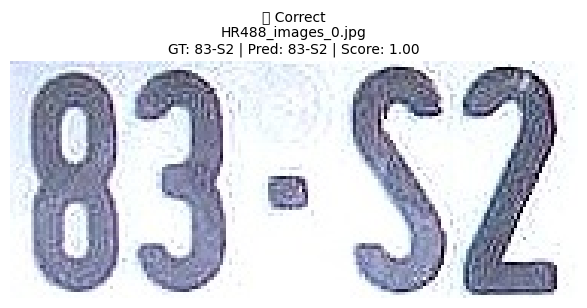

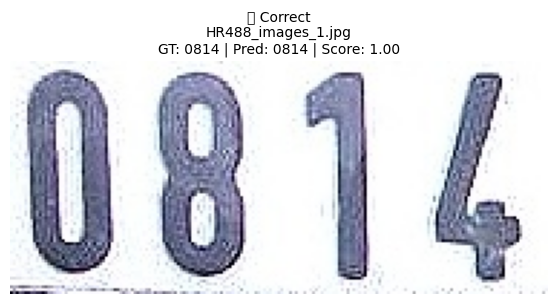

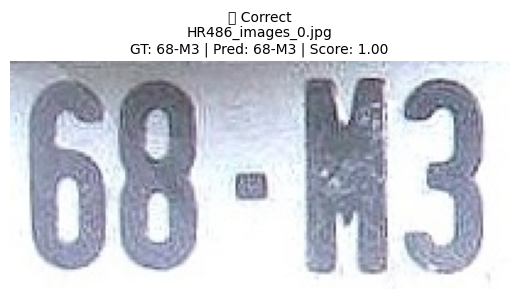

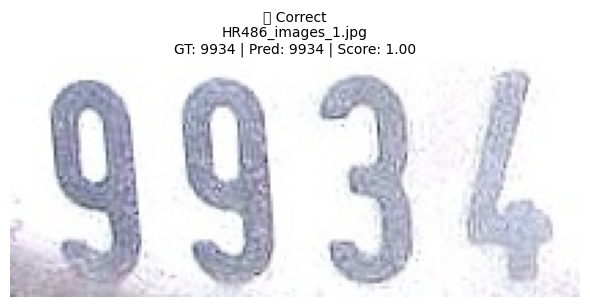

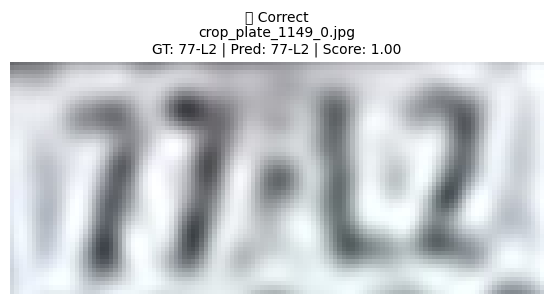


❌ Ví dụ CASE SAI:


<ipython-input-9-87529fc1f856>:60: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


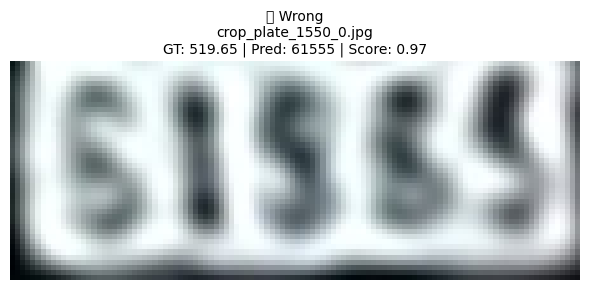

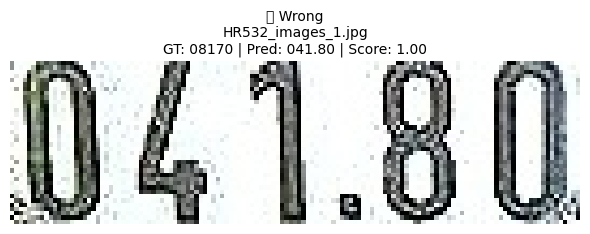

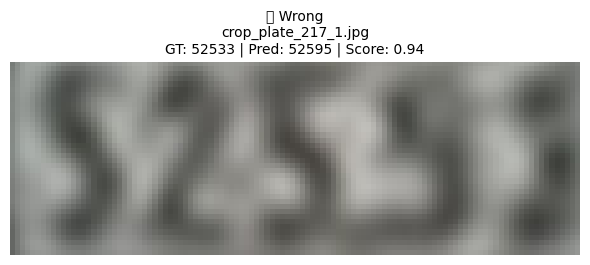

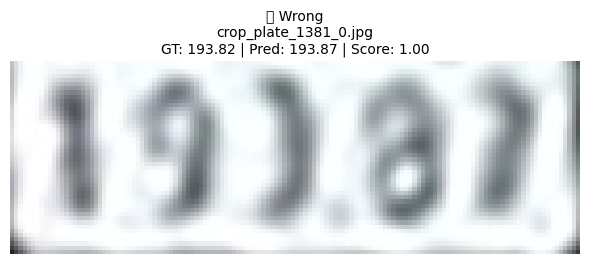

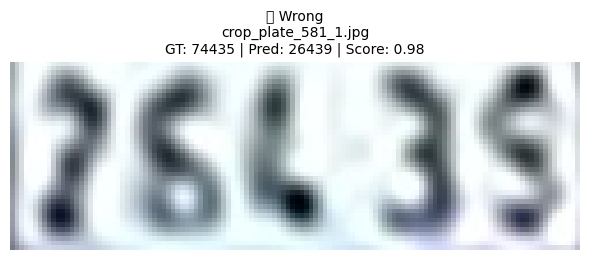

In [9]:
import os
import re
import cv2
import matplotlib.pyplot as plt

# ===== ĐƯỜNG DẪN =====
gt_file = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/rec_gt_val_fix.txt"
pred_file = "/content/drive/MyDrive/AIP491/Training/PaddleOCR/inference/rec_result/rec_predict_log_2004.txt"
image_dir = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_1804/rec/val_set"

# ===== 1. Đọc Ground Truth =====
gt_dict = {}
with open(gt_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:

            filename = os.path.basename(parts[0])
            gt_dict[filename] = parts[1].strip()

# ===== 2. Đọc Predict Log =====
pred_dict = {}
with open(pred_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        if "infer_img" in lines[i]:
            match = re.search(r"val_set/([^\s]+\.jpg)", lines[i])
            if match:
                filename = match.group(1)
                if i + 1 < len(lines) and "result:" in lines[i + 1]:
                    result_line = lines[i + 1].split("result:")[-1].strip()
                    parts = result_line.split('\t')
                    if len(parts) == 2:
                        pred_text, score = parts
                        pred_dict[filename] = (pred_text.strip(), float(score))

# ===== 3. So sánh & phân loại =====
correct_cases = []
wrong_cases = []

for filename, gt_text in gt_dict.items():
    if filename in pred_dict:
        pred_text, score = pred_dict[filename]
        if pred_text == gt_text:
            correct_cases.append((filename, gt_text, pred_text, score))
        else:
            wrong_cases.append((filename, gt_text, pred_text, score))

# ===== 4. Hàm hiển thị ảnh =====
def draw_case(img_name, gt, pred, score, title):
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Không tìm thấy ảnh: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 3))
    plt.imshow(img)
    plt.title(f"{title}\n{img_name}\nGT: {gt} | Pred: {pred} | Score: {score:.2f}", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ===== 5. Debug thống kê =====
print(f"\n📊 Tổng ảnh GT: {len(gt_dict)}")
print(f"✅ Số case đúng: {len(correct_cases)}")
print(f"❌ Số case sai: {len(wrong_cases)}")

# ===== 6. Vẽ một vài ví dụ =====
print("\n✅ Ví dụ CASE ĐÚNG:")
for case in correct_cases[:5]:
    draw_case(*case, title="✅ Correct")

print("\n❌ Ví dụ CASE SAI:")
for case in wrong_cases[:5]:
    draw_case(*case, title="❌ Wrong")

# ===== 7. Lưu 100 case sai đầu tiên =====
import shutil

# Tạo folder output
output_img_dir = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/wrong_cases_images"
output_label_file = "/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_2004/rec/wrong_cases_labels.txt"
os.makedirs(output_img_dir, exist_ok=True)

# Lưu ảnh và ghi label
with open(output_label_file, 'w', encoding='utf-8') as label_out:
    for idx, (filename, gt_text, pred_text, score) in enumerate(wrong_cases[:200]):
        src_img_path = os.path.join(image_dir, filename)
        new_img_name = f"{os.path.splitext(filename)[0]}_{idx}.jpg"
        dst_img_path = os.path.join(output_img_dir, new_img_name)

        # Copy ảnh
        if os.path.exists(src_img_path):
            shutil.copy(src_img_path, dst_img_path)
            # Ghi label là Ground Truth
            label_out.write(f"{new_img_name}\t{gt_text}\n")
        else:
            print(f"⚠️ Không tìm thấy ảnh: {src_img_path}")



🔍 Tổng số ảnh cần hiển thị: 130 (chia mỗi lần 10 ảnh)


🖼️ Hiển thị ảnh từ 1 đến 10:


<ipython-input-9-87529fc1f856>:60: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


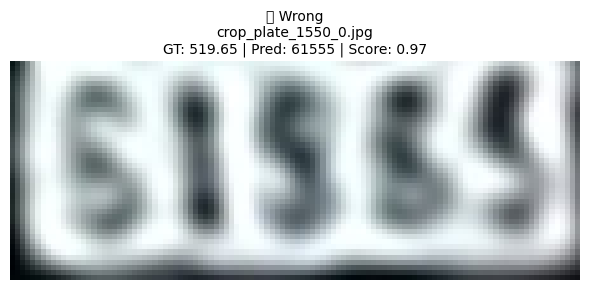

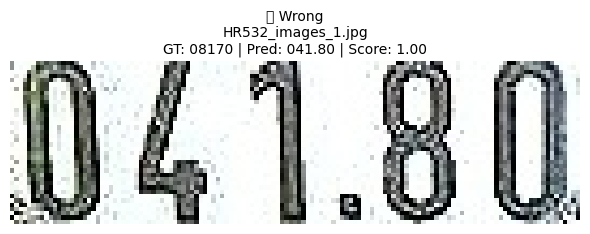

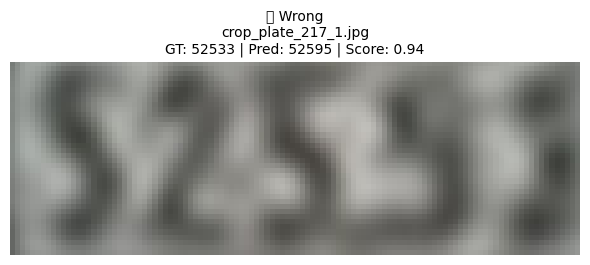

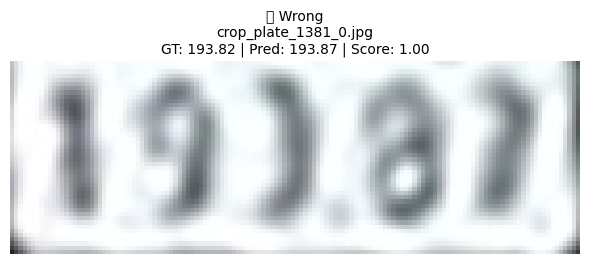

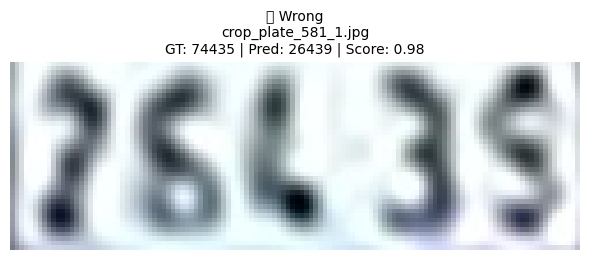

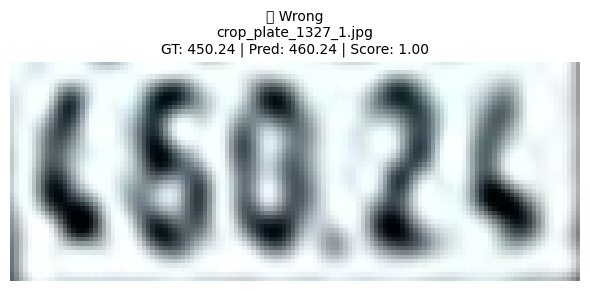

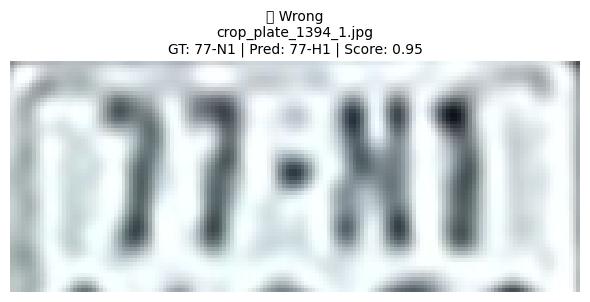

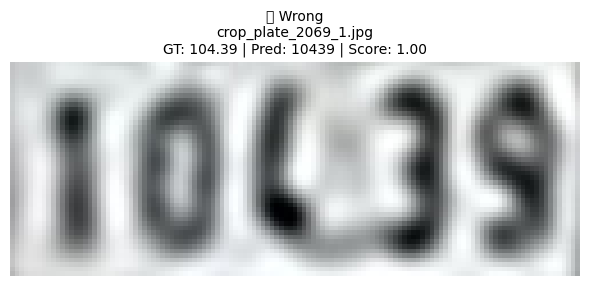

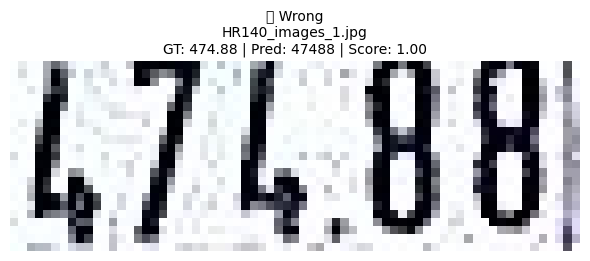

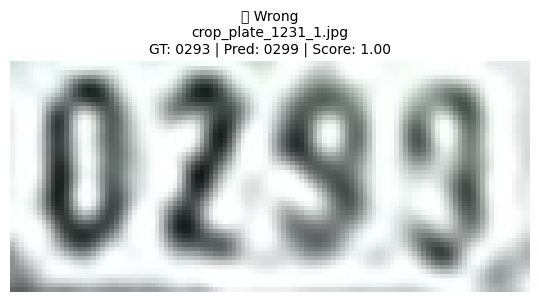

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 11 đến 20:


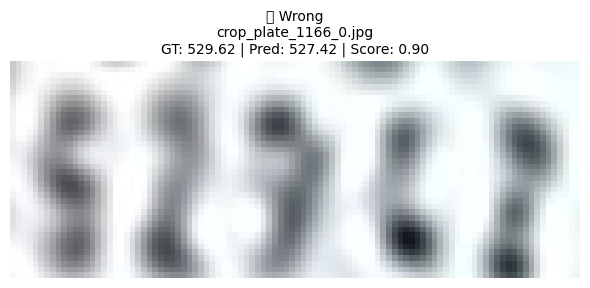

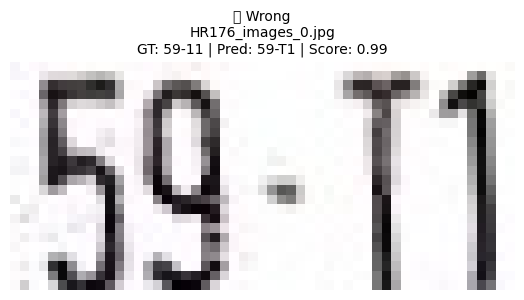

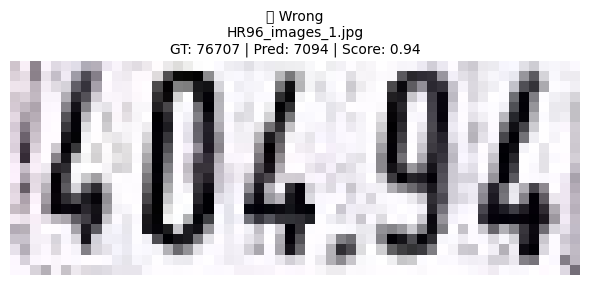

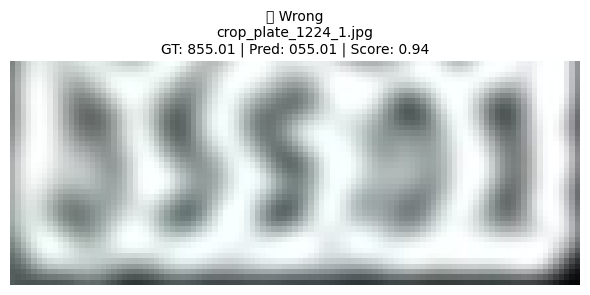

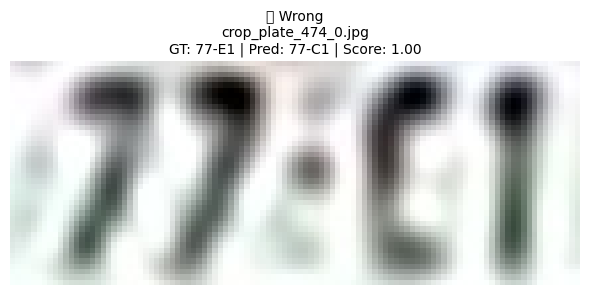

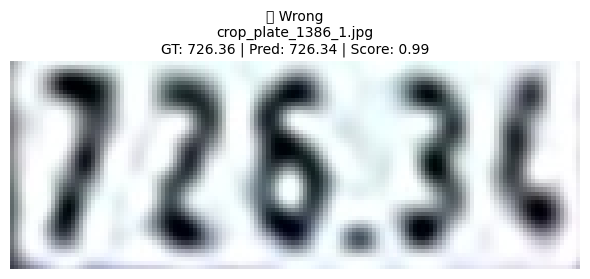

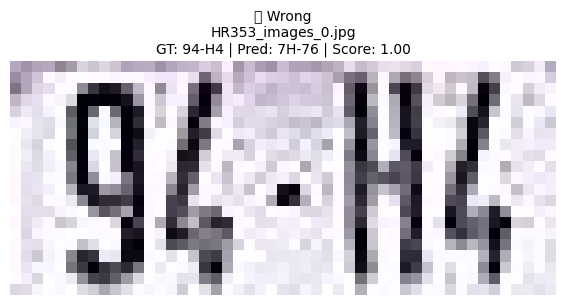

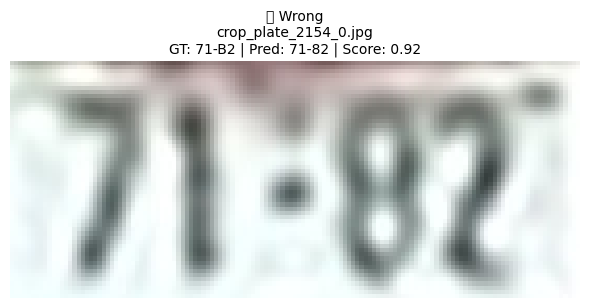

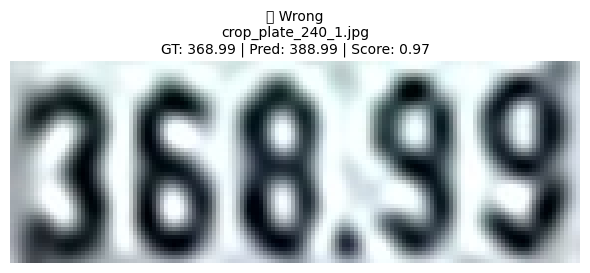

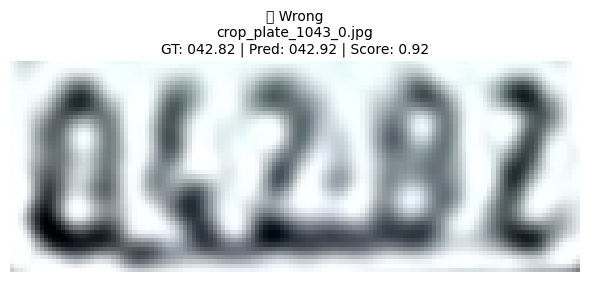

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 21 đến 30:


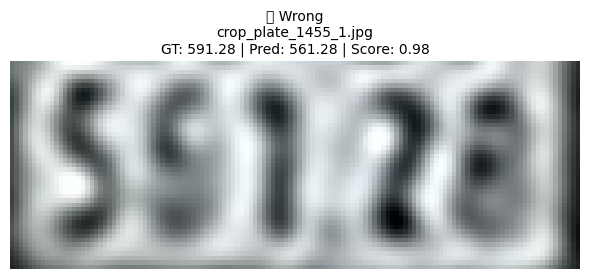

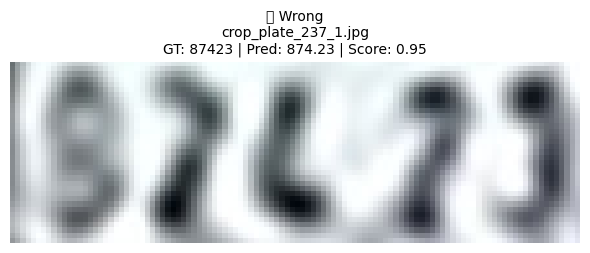

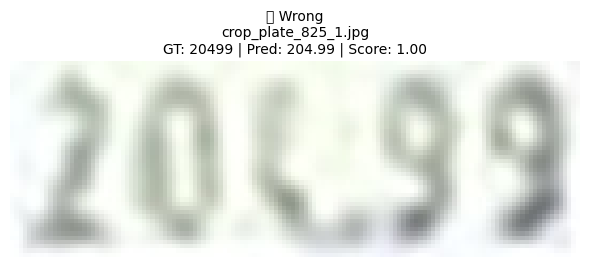

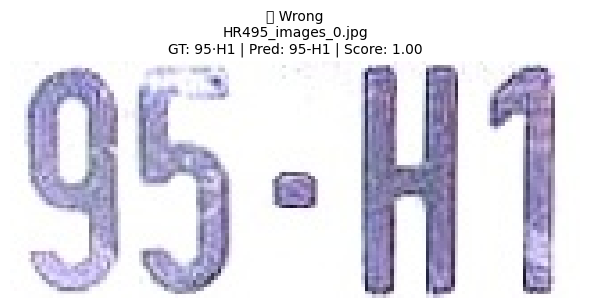

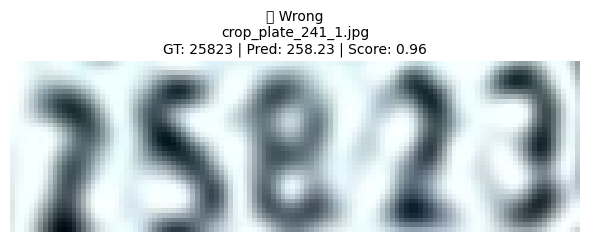

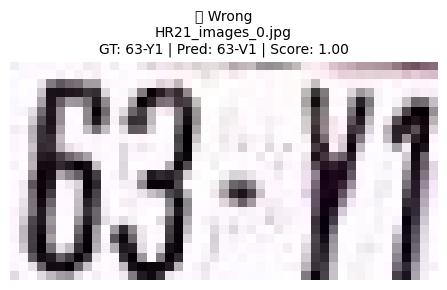

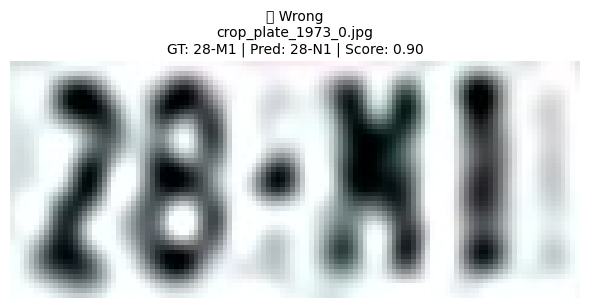

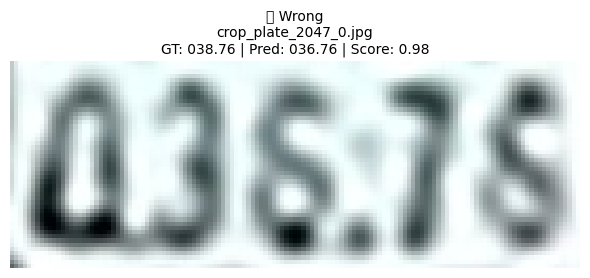

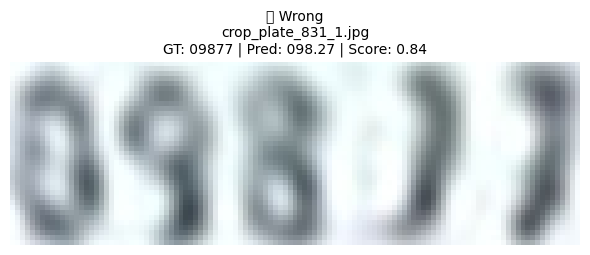

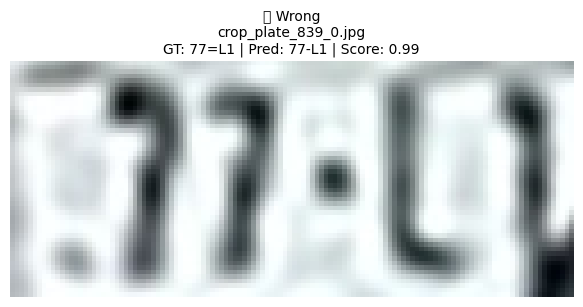

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 31 đến 40:


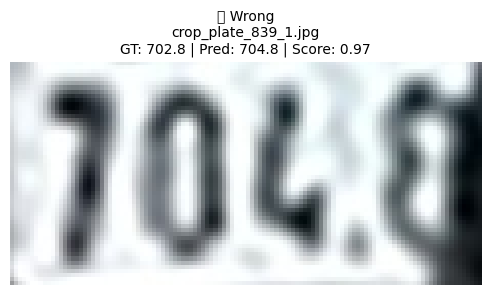

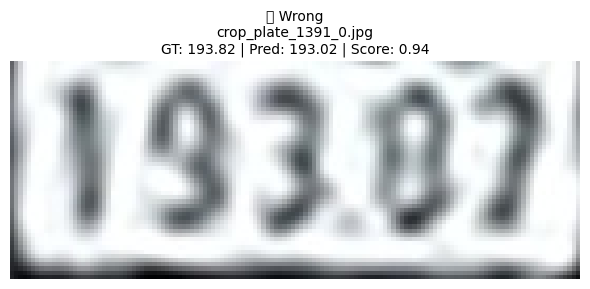

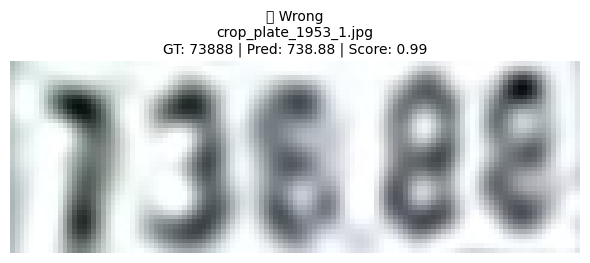

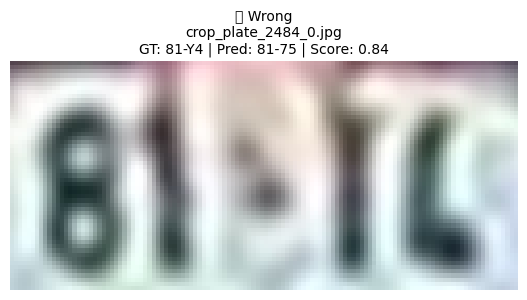

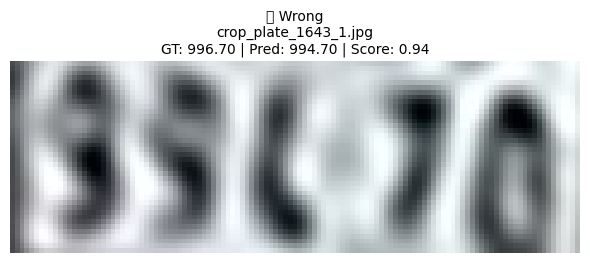

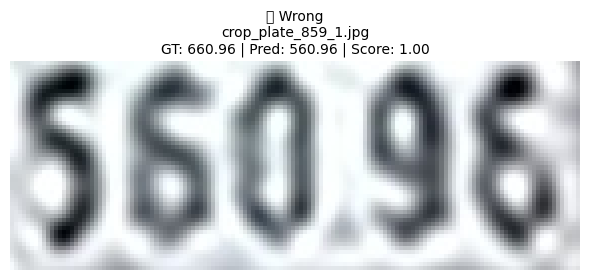

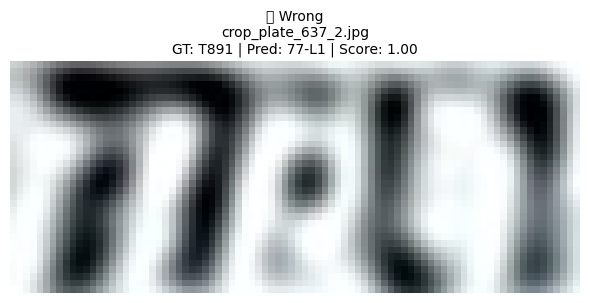

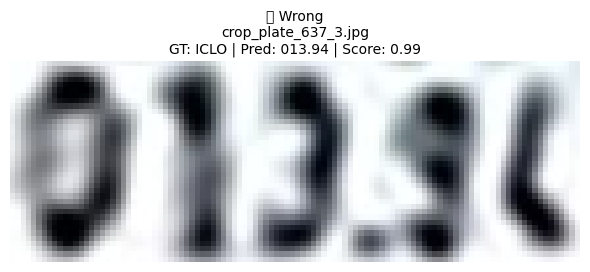

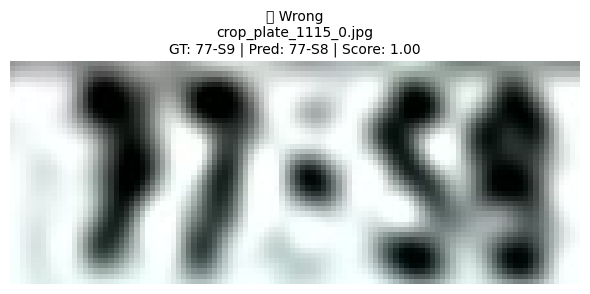

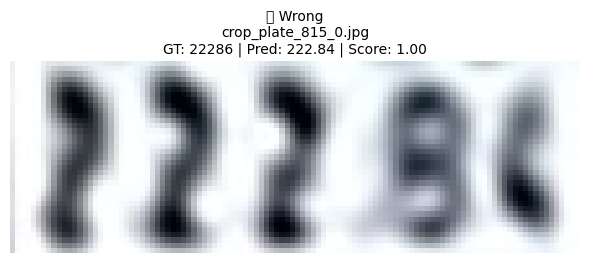

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 41 đến 50:


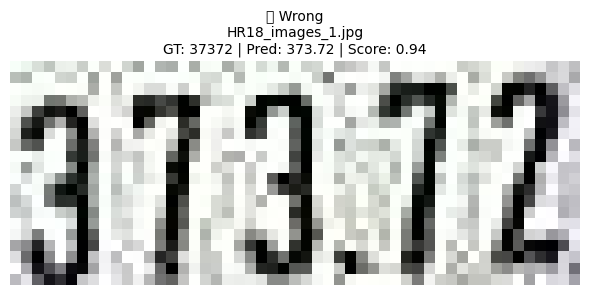

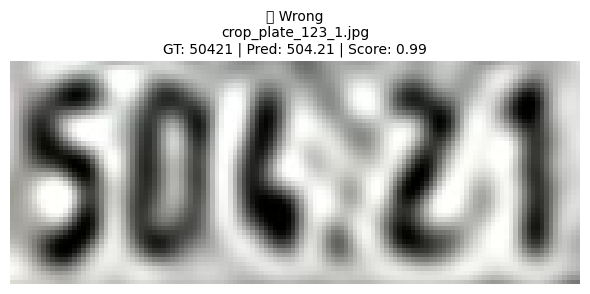

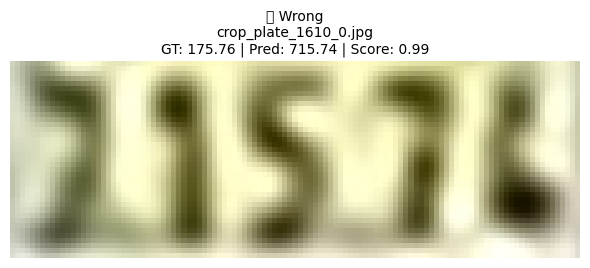

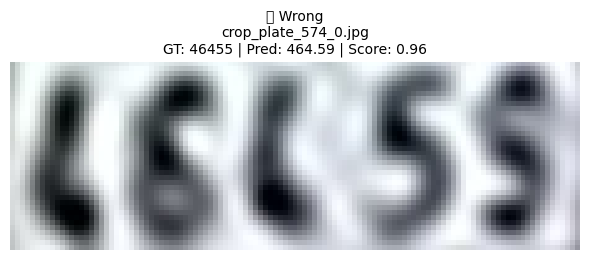

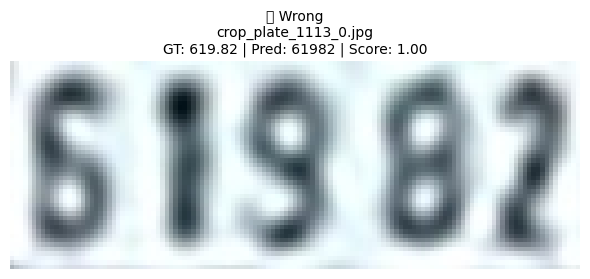

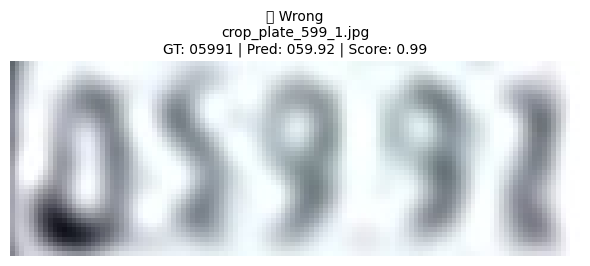

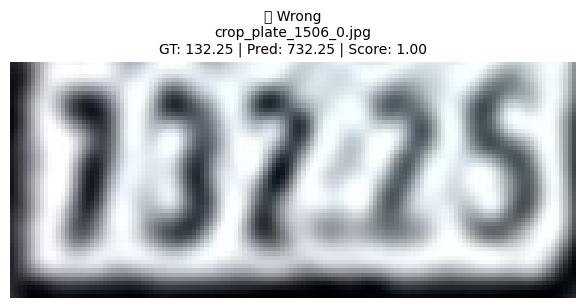

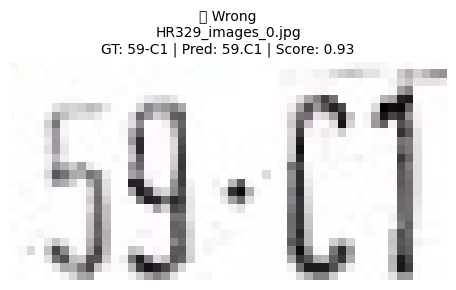

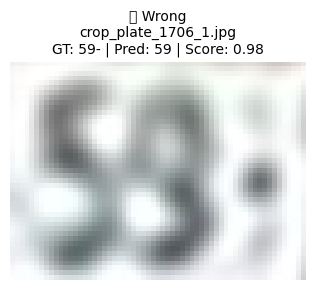

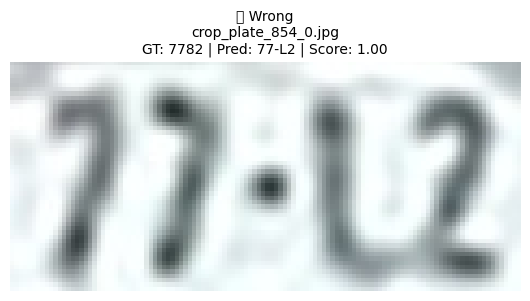

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 51 đến 60:


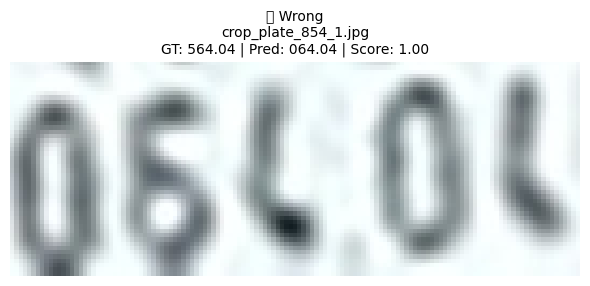

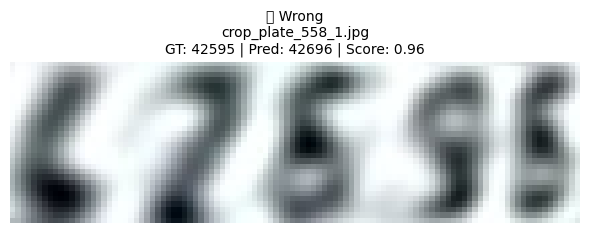

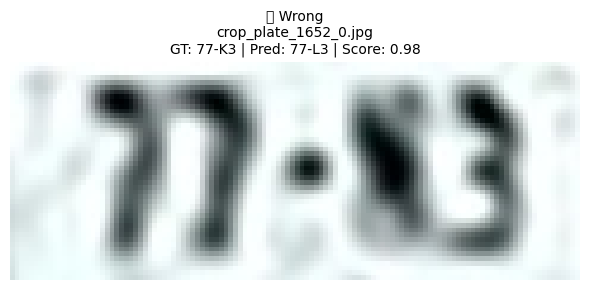

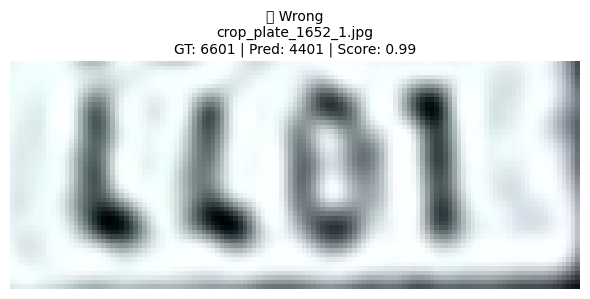

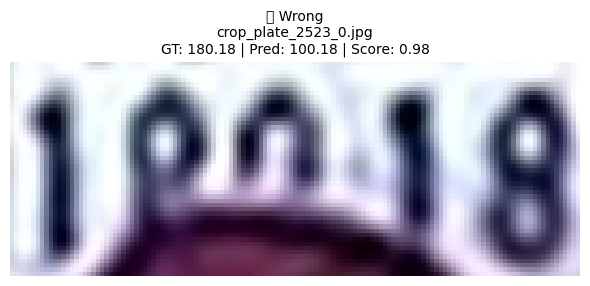

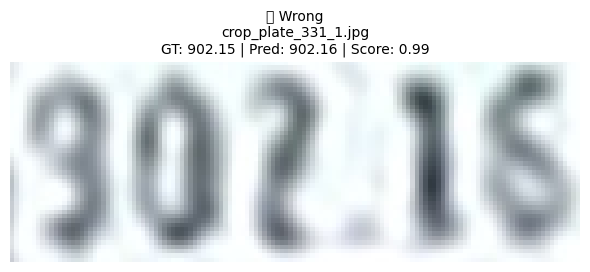

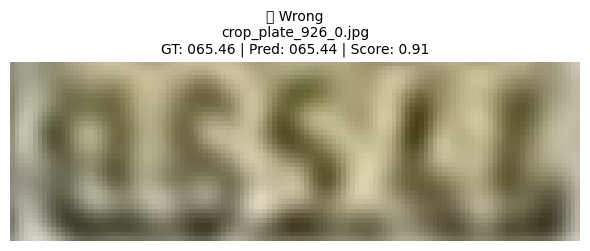

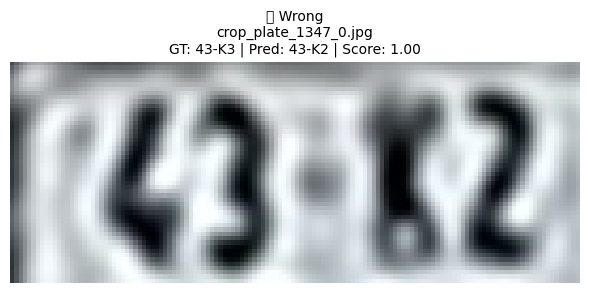

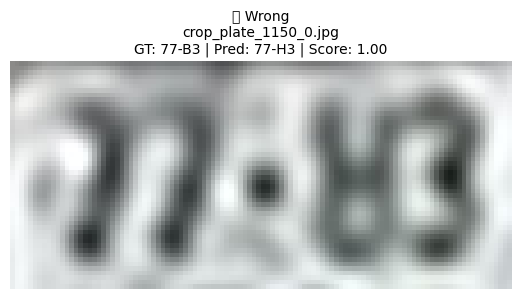

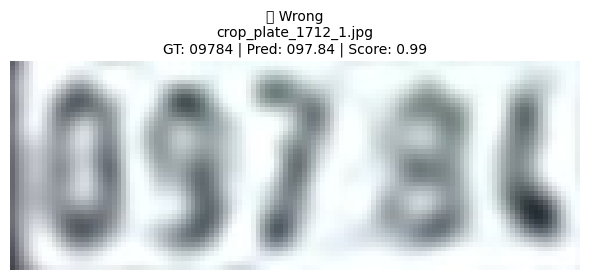

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 61 đến 70:


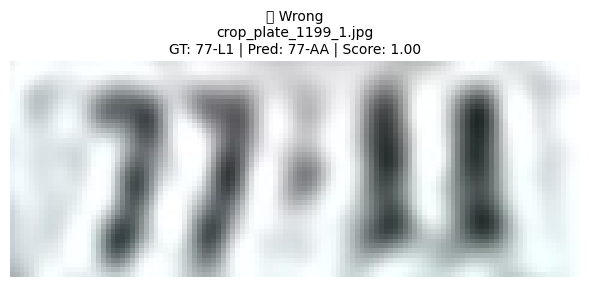

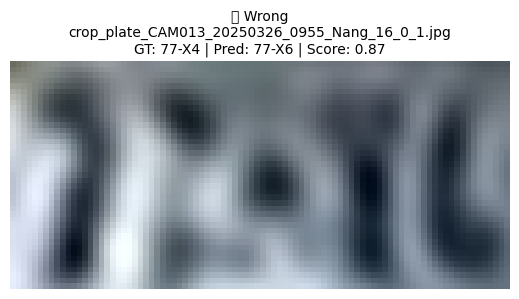

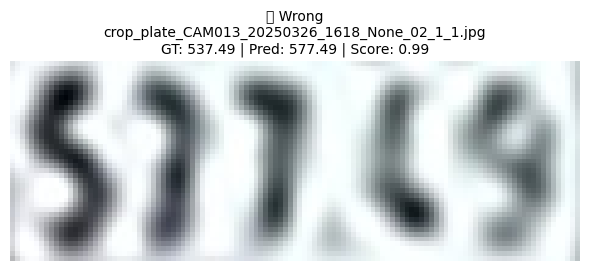

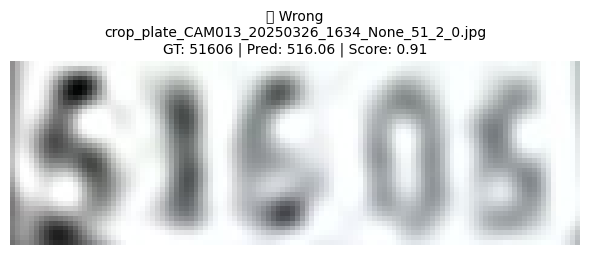

<ipython-input-9-87529fc1f856>:60: UserWarning: Glyph 24453 (\N{CJK UNIFIED IDEOGRAPH-5F85}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-87529fc1f856>:60: UserWarning: Glyph 35782 (\N{CJK UNIFIED IDEOGRAPH-8BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-87529fc1f856>:60: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24453 (\N{CJK UNIFIED IDEOGRAPH-5F85}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35782 (\N{CJK UNIFIED IDEOGRAPH-8BC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from f

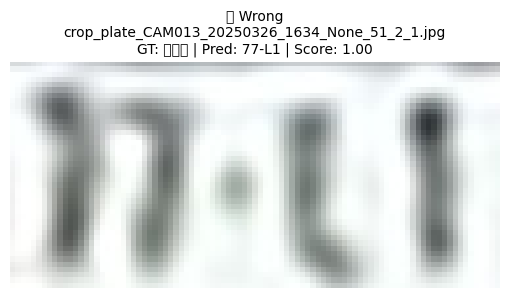

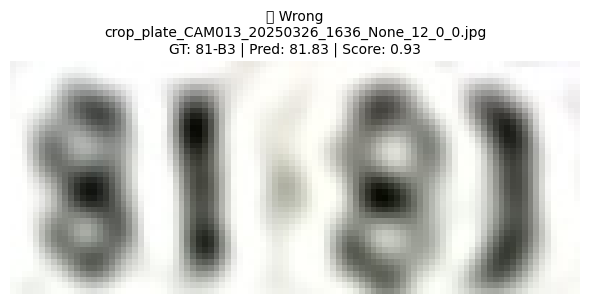

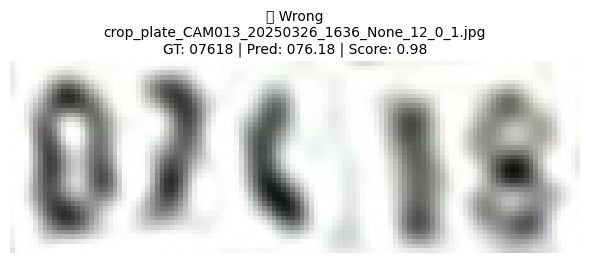

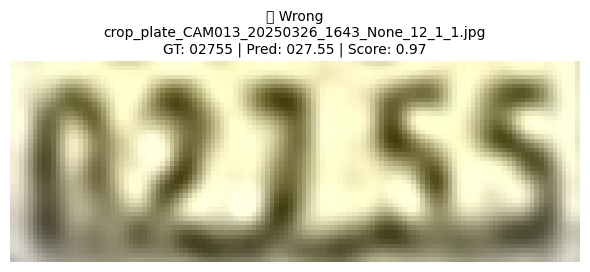

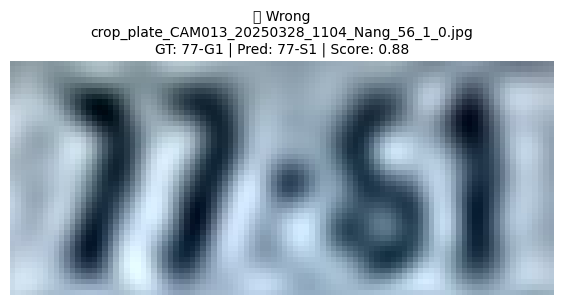

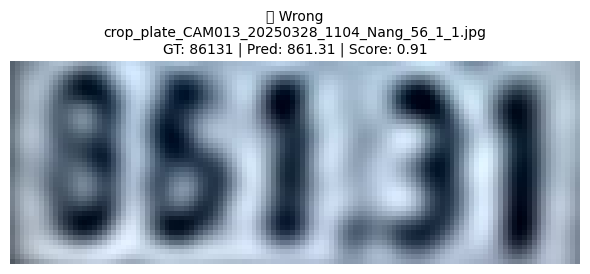

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 71 đến 80:


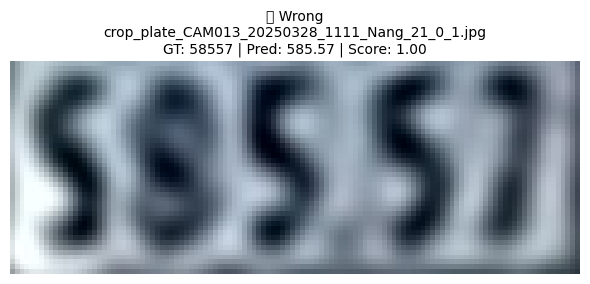

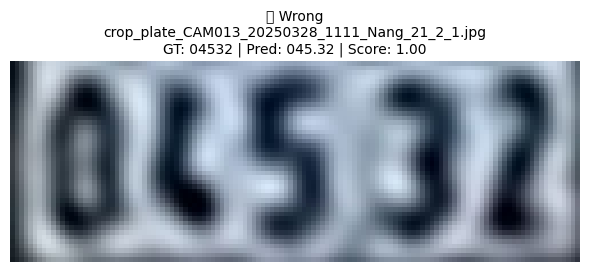

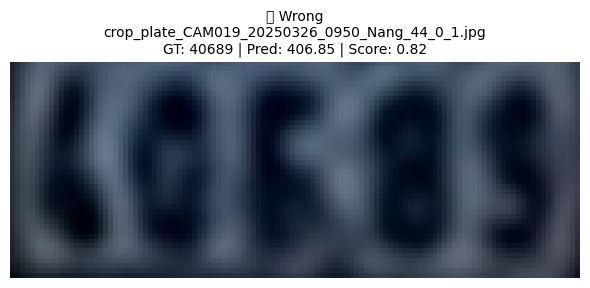

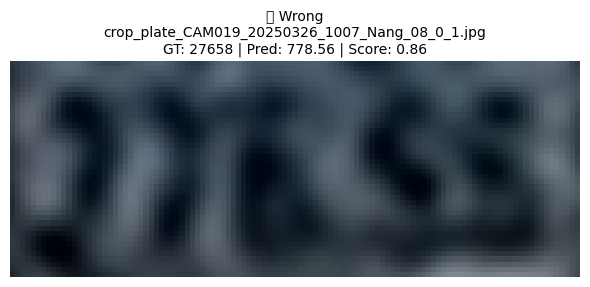

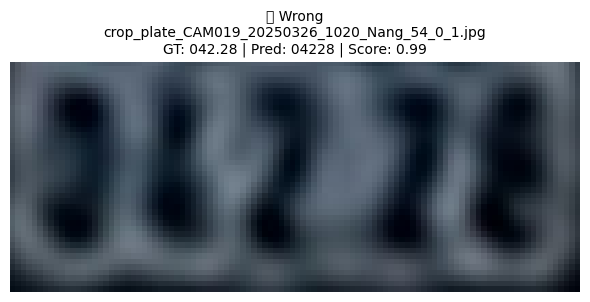

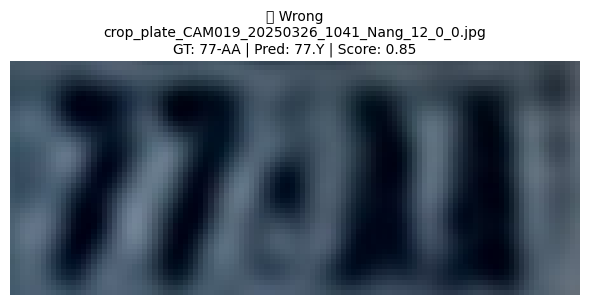

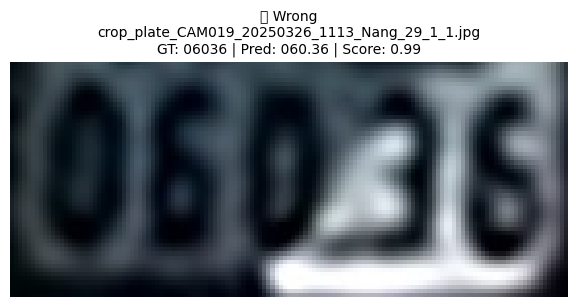

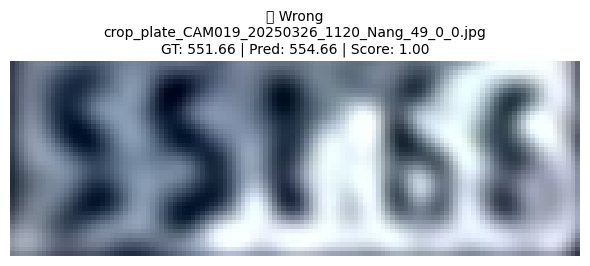

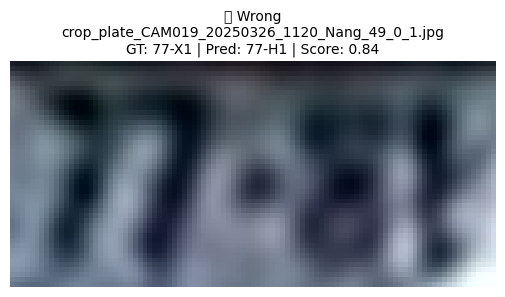

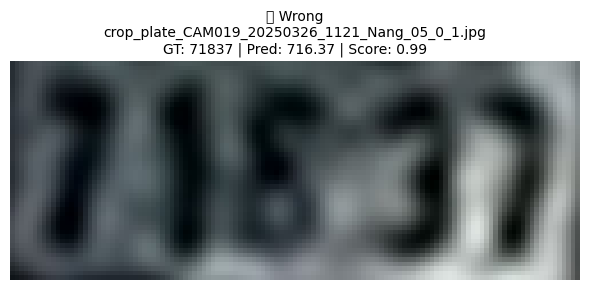

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 81 đến 90:


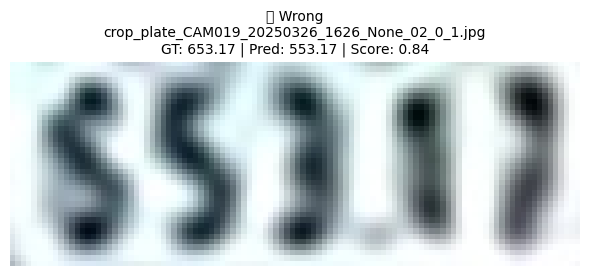

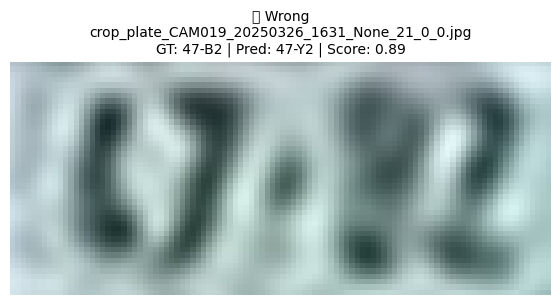

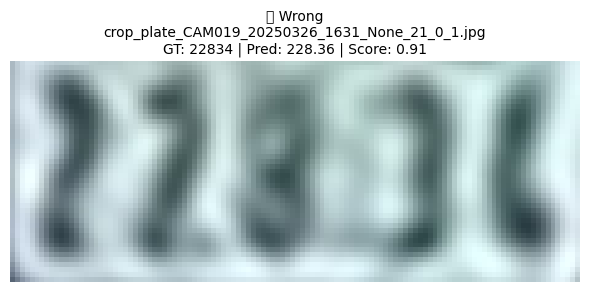

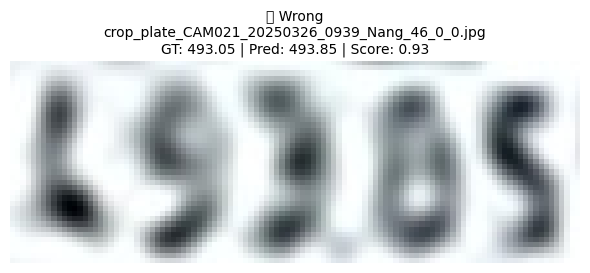

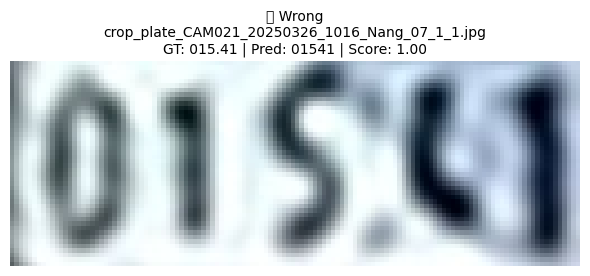

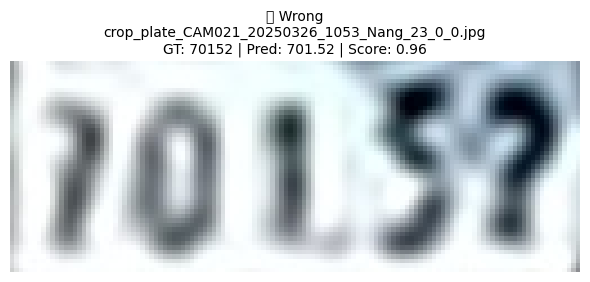

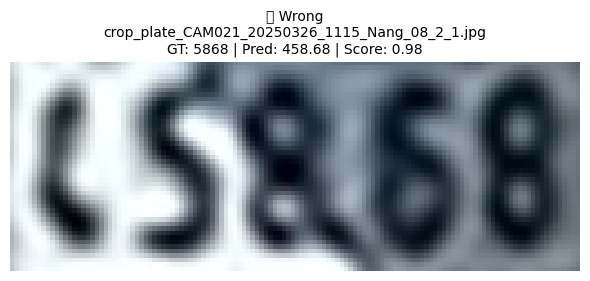

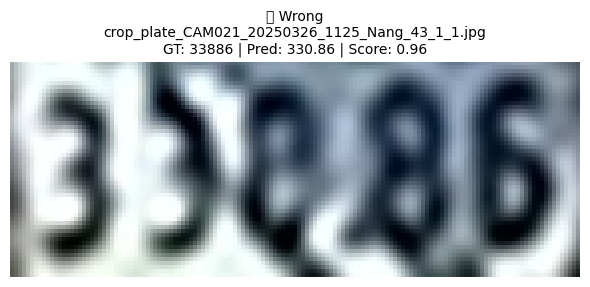

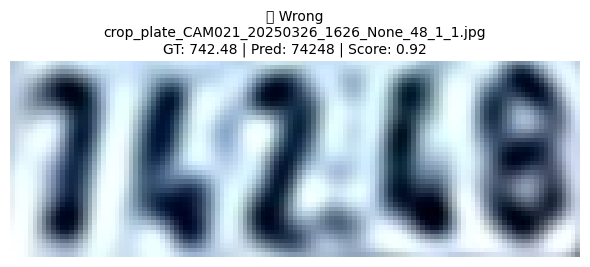

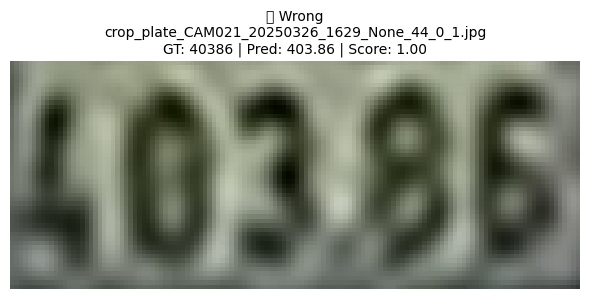

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 91 đến 100:


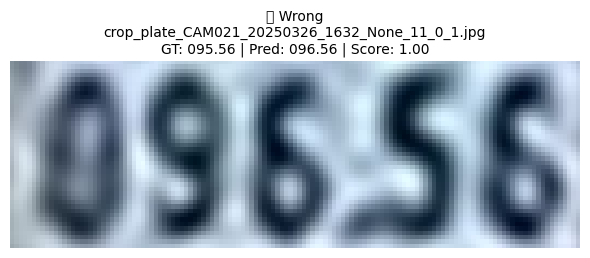

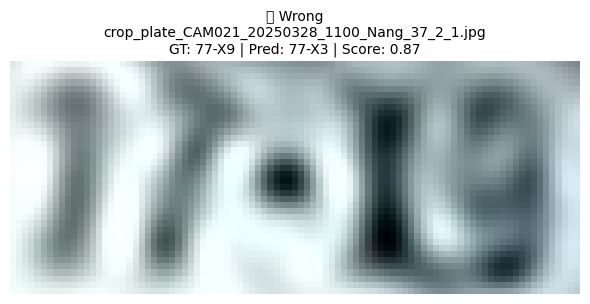

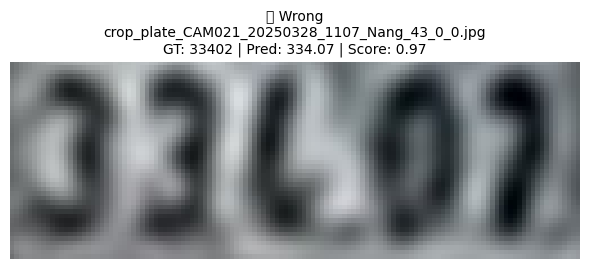

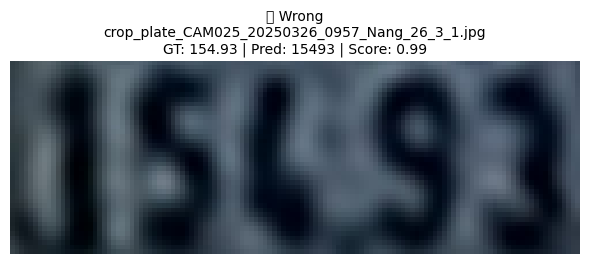

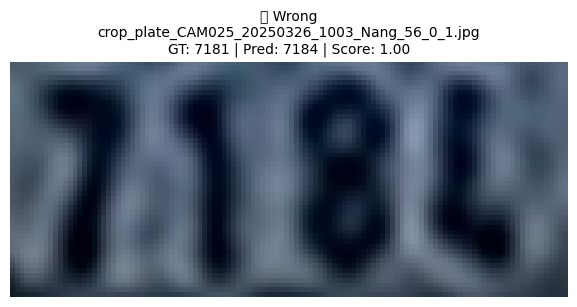

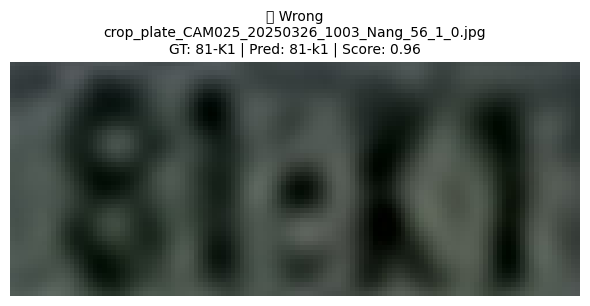

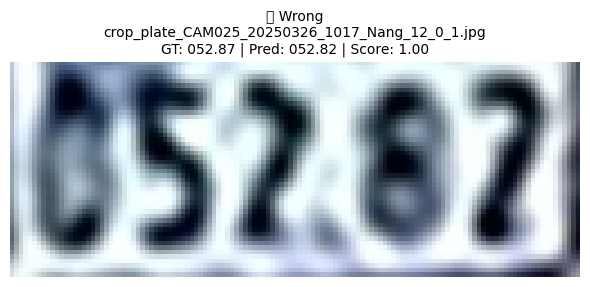

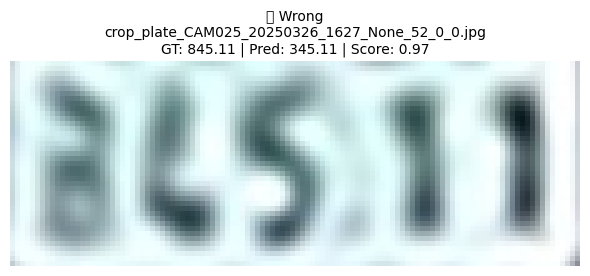

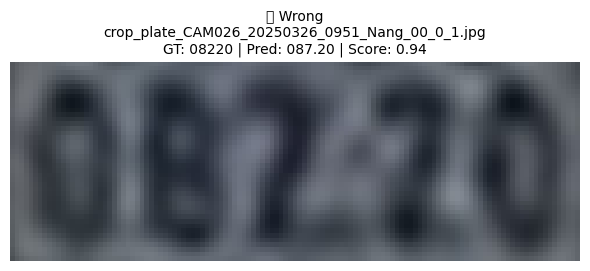

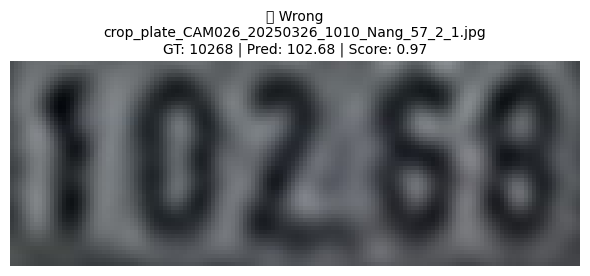

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 101 đến 110:


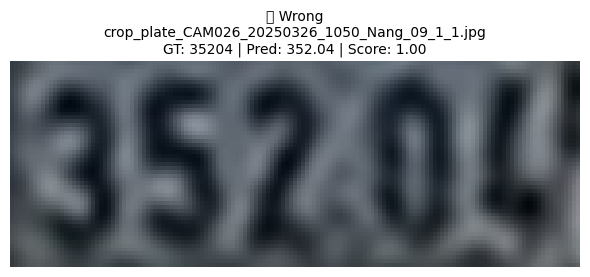

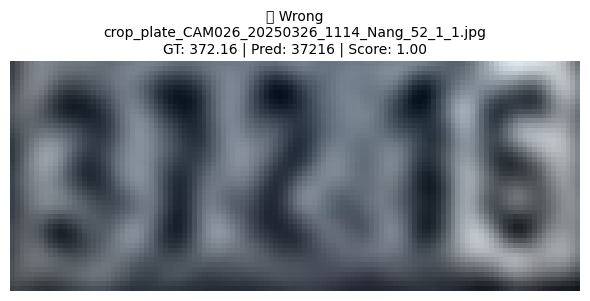

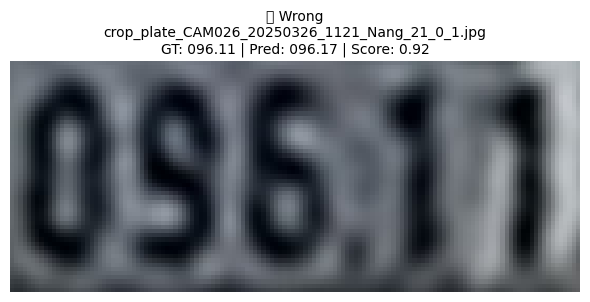

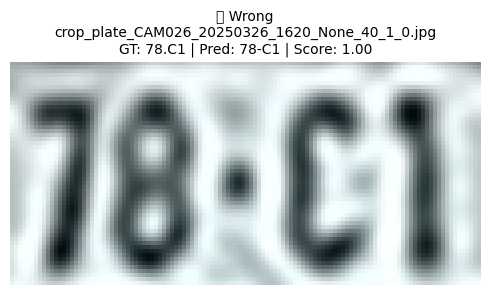

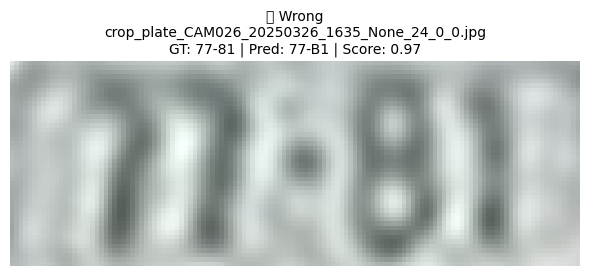

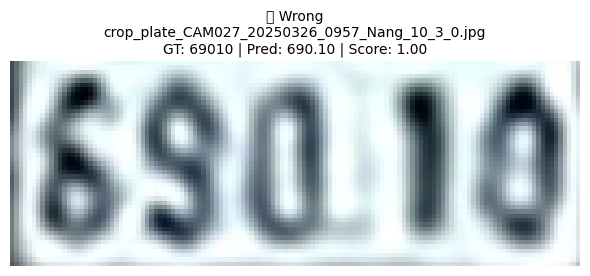

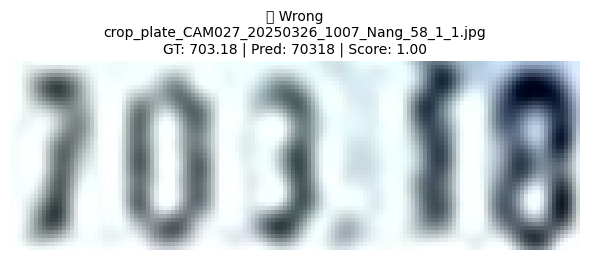

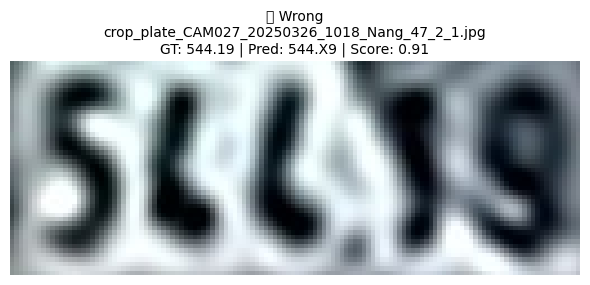

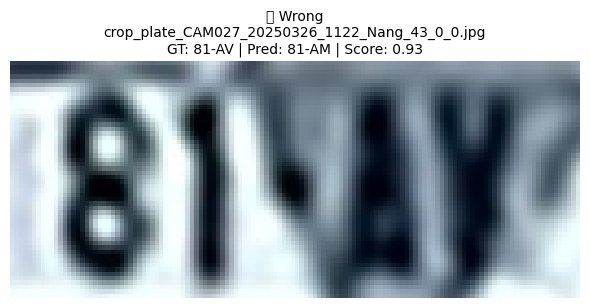

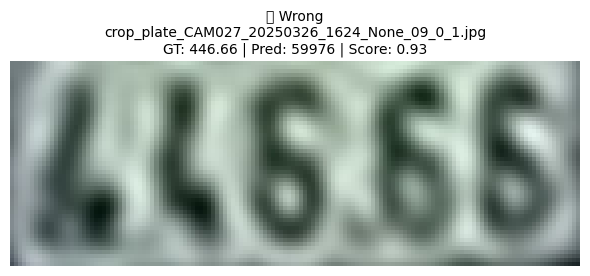

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 111 đến 120:


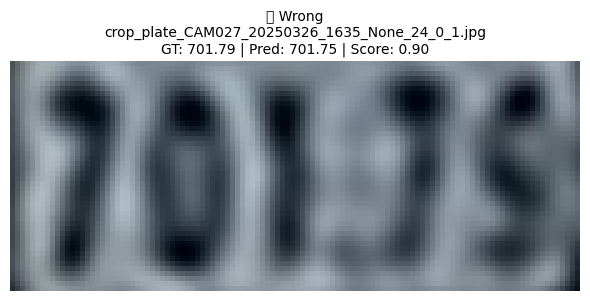

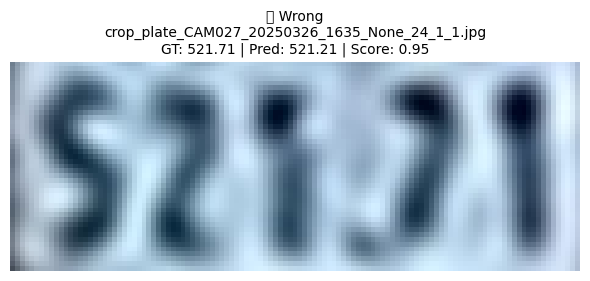

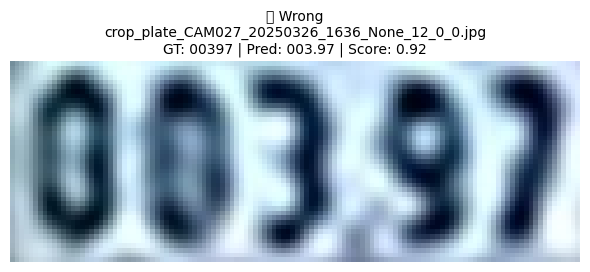

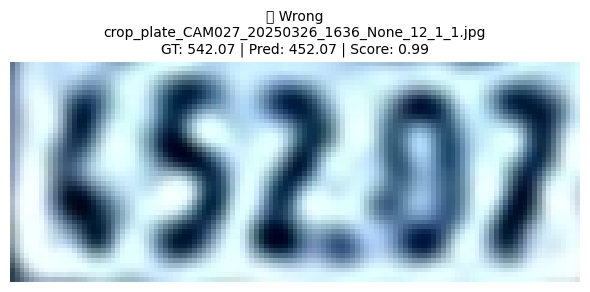

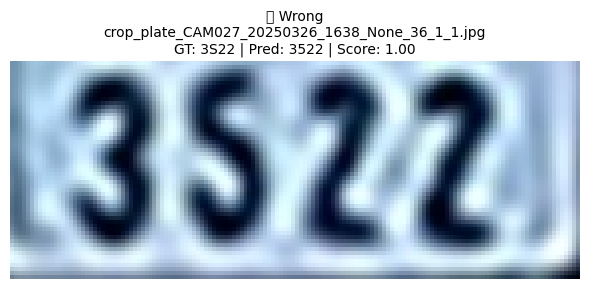

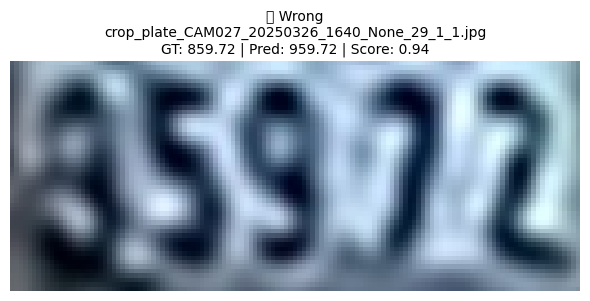

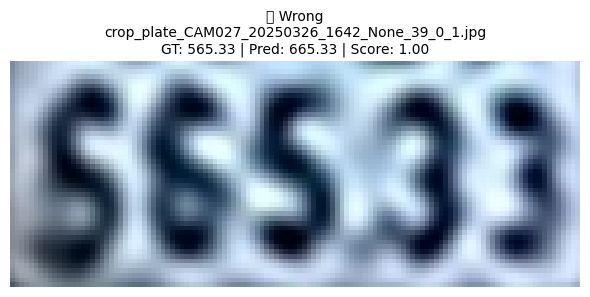

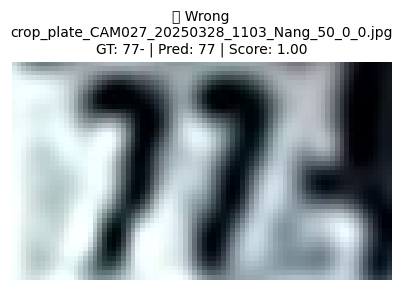

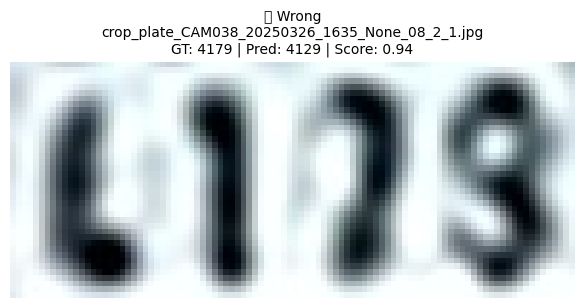

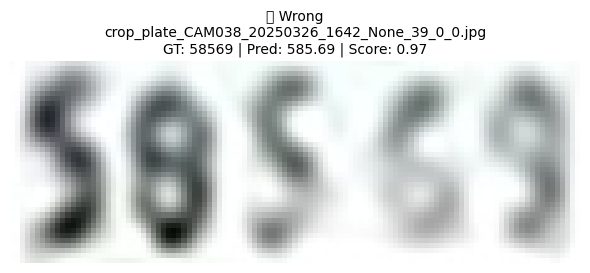

⏸ Nhấn Enter để xem batch tiếp theo...

🖼️ Hiển thị ảnh từ 121 đến 130:


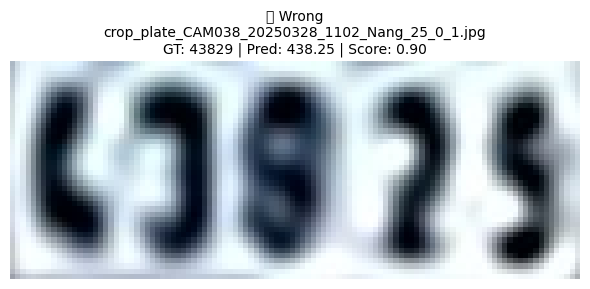

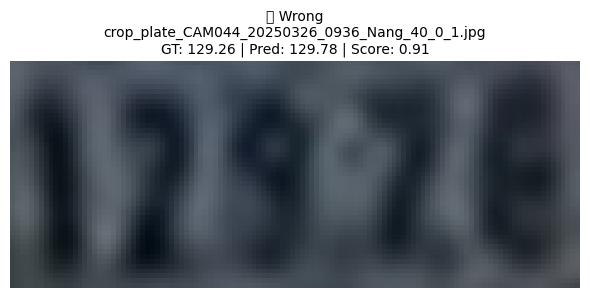

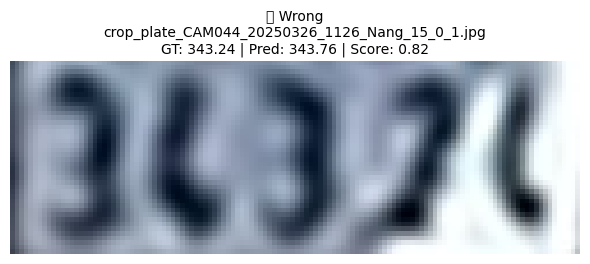

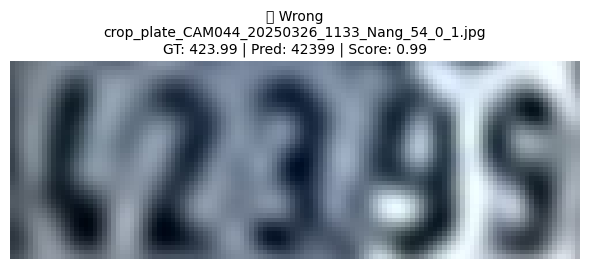

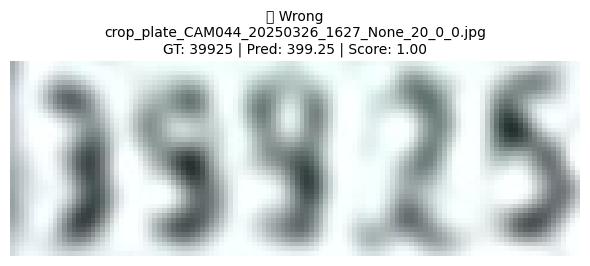

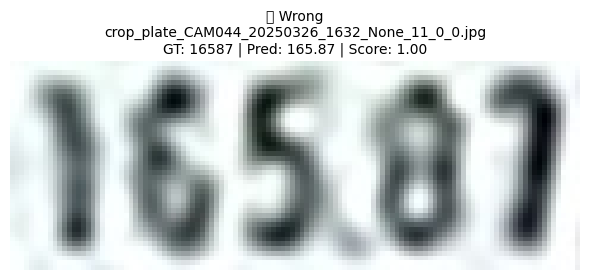

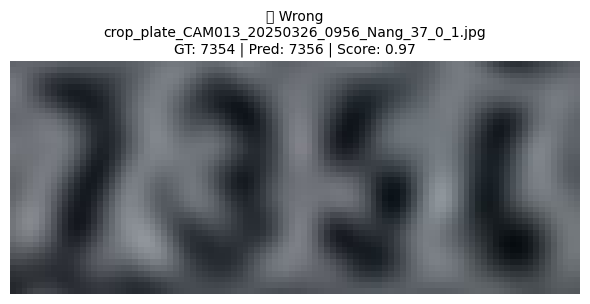

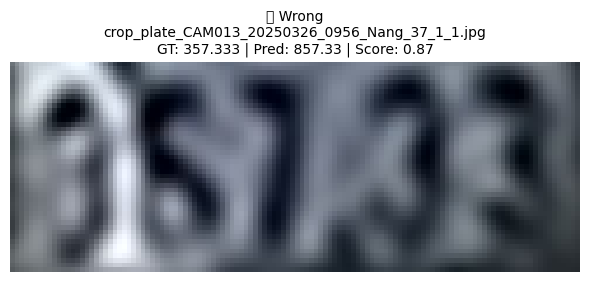

⏸ Nhấn Enter để xem batch tiếp theo...


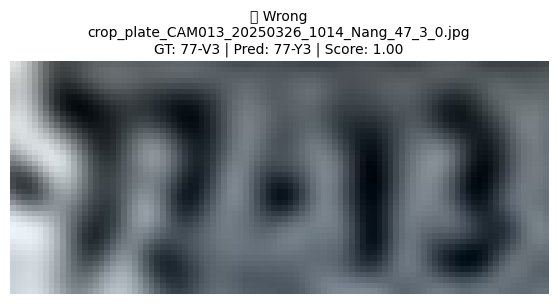

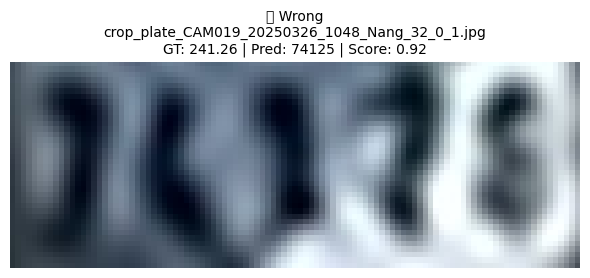

In [10]:
# ===== Hiển thị 130 ảnh sai: chia batch 10 ảnh =====
import time

batch_size = 10
total_to_show = 130

print(f"🔍 Tổng số ảnh cần hiển thị: {total_to_show} (chia mỗi lần {batch_size} ảnh)\n")

for i in range(0, total_to_show, batch_size):
    batch = wrong_cases[i:i+batch_size]
    print(f"\n🖼️ Hiển thị ảnh từ {i+1} đến {i+len(batch)}:")
    for case in batch:
        draw_case(*case, title="❌ Wrong")
    input("⏸ Nhấn Enter để xem batch tiếp theo...")  # Dừng lại mỗi lô


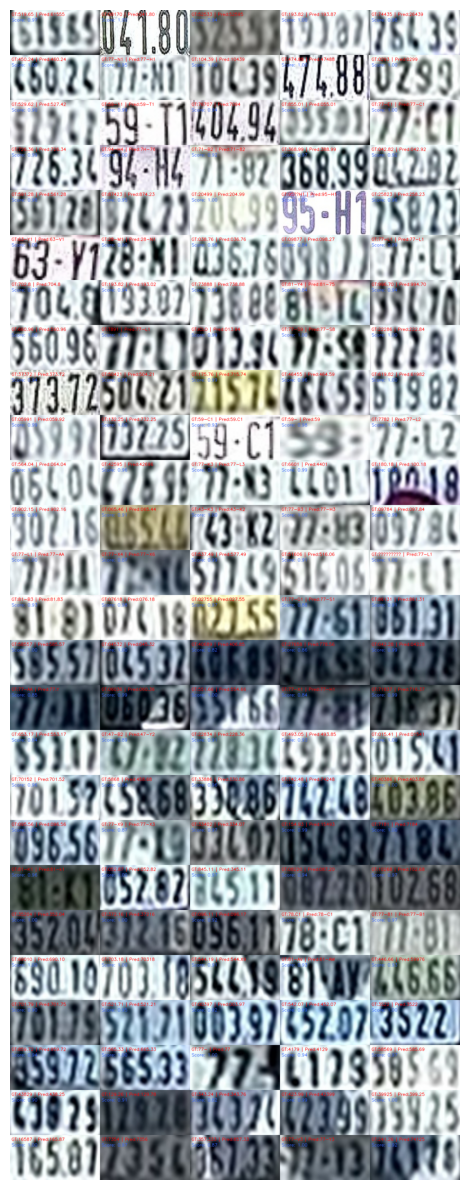

In [11]:
def draw_grid_of_wrong_cases(cases, cols=5, img_size=(320, 160), save_path=None):
    import numpy as np

    rows = (len(cases) + cols - 1) // cols
    blank_img = np.ones((img_size[1], img_size[0], 3), dtype=np.uint8) * 255  # ảnh trắng nếu thiếu slot
    grid_rows = []

    for row_idx in range(rows):
        row_imgs = []
        for col_idx in range(cols):
            idx = row_idx * cols + col_idx
            if idx >= len(cases):
                row_imgs.append(blank_img)
                continue

            filename, gt, pred, score = cases[idx]
            img_path = os.path.join(image_dir, filename)
            img = cv2.imread(img_path)

            if img is None:
                print(f"⚠️ Không tìm thấy ảnh: {img_path}")
                row_imgs.append(blank_img)
                continue

            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Ghi text lên ảnh
            text = f"GT:{gt} | Pred:{pred}"
            img = cv2.putText(img, text, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
            score_text = f"Score: {score:.2f}"
            img = cv2.putText(img, score_text, (5, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (50, 100, 255), 1, cv2.LINE_AA)

            row_imgs.append(img)

        row_concat = np.hstack(row_imgs)
        grid_rows.append(row_concat)

    grid_img = np.vstack(grid_rows)

    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(grid_img, cv2.COLOR_RGB2BGR))
        print(f"✅ Đã lưu grid ảnh vào: {save_path}")
    else:
        plt.figure(figsize=(16, 12))
        plt.imshow(grid_img)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
draw_grid_of_wrong_cases(wrong_cases[:130], cols=5, img_size=(320, 160))


In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import random

def analyze_by_length(correct_cases, wrong_cases, show_example_per_length=2):
    length_stats = defaultdict(lambda: {"correct": 0, "wrong": 0, "correct_samples": [], "wrong_samples": []})

    # Đếm đúng / sai và lưu ví dụ
    for case in correct_cases:
        length = len(case[1])
        length_stats[length]["correct"] += 1
        length_stats[length]["correct_samples"].append(case)

    for case in wrong_cases:
        length = len(case[1])
        length_stats[length]["wrong"] += 1
        length_stats[length]["wrong_samples"].append(case)

    lengths = sorted(length_stats.keys())
    correct_counts = [length_stats[l]["correct"] for l in lengths]
    wrong_counts = [length_stats[l]["wrong"] for l in lengths]
    total_counts = [c + w for c, w in zip(correct_counts, wrong_counts)]
    accuracy = [100 * c / (c + w) if (c + w) > 0 else 0 for c, w in zip(correct_counts, wrong_counts)]

    # Vẽ biểu đồ stacked bar
    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(lengths, correct_counts, label='✅ Correct', color='green')
    bars2 = plt.bar(lengths, wrong_counts, bottom=correct_counts, label='❌ Wrong', color='red')

    # Hiển thị accuracy %
    for i, (x, acc) in enumerate(zip(lengths, accuracy)):
        plt.text(x, total_counts[i] + 0.5, f"{acc:.0f}%", ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.xlabel('Length of Ground Truth (characters)')
    plt.ylabel('Number of Samples')
    plt.title('🎯 Accuracy by Length of Plate Text')
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()

    # 📌 In ví dụ minh họa
    print("\n📚 Example Samples per Length:")
    for l in lengths:
        print(f"\n--- Length {l} ---")
        # Đúng
        correct_ex = length_stats[l]["correct_samples"]
        if correct_ex:
            print("✅ Correct Examples:")
            for case in random.sample(correct_ex, min(show_example_per_length, len(correct_ex))):
                print(f"  GT: {case[1]} | Pred: {case[2]} | Score: {case[3]:.2f}")
        # Sai
        wrong_ex = length_stats[l]["wrong_samples"]
        if wrong_ex:
            print("❌ Wrong Examples:")
            for case in random.sample(wrong_ex, min(show_example_per_length, len(wrong_ex))):
                print(f"  GT: {case[1]} | Pred: {case[2]} | Score: {case[3]:.2f}")


In [ ]:
# 3. Phân tích theo score
def analyze_by_score(wrong_cases, bins=[0.5, 0.7, 0.8, 0.9, 1.0]):
    import numpy as np

    scores = [score for _, _, _, score in wrong_cases]
    plt.figure(figsize=(8, 4))
    plt.hist(scores, bins=bins, edgecolor='black', color='salmon')
    plt.title("❌ Score Distribution of Wrong Predictions")
    plt.xlabel("Confidence Score")
    plt.ylabel("Number of Wrong Predictions")
    plt.tight_layout()
    plt.show()


In [ ]:
# 4. Phân tích lỗi ký tự
from collections import Counter

def analyze_char_level_mistakes(wrong_cases):
    from difflib import SequenceMatcher

    counter = Counter()

    for _, gt, pred, _ in wrong_cases:
        matcher = SequenceMatcher(None, gt, pred)
        for tag, i1, i2, j1, j2 in matcher.get_opcodes():
            if tag in ["replace", "delete", "insert"]:
                gt_sub = gt[i1:i2]
                pred_sub = pred[j1:j2]
                counter[(gt_sub, pred_sub)] += 1

    print("\n🔠 Top character-level mistakes:")
    for (gt_c, pred_c), count in counter.most_common(10):
        print(f"GT: '{gt_c}' → Pred: '{pred_c}' | {count} lần")


In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import random

def analyze_char_error_rate_with_examples(correct_cases, wrong_cases, top_k=5, min_count=5, examples_per_char=3):
    char_stats = defaultdict(lambda: {
        "wrong": 0,
        "total": 0,
        "wrong_examples": [],
        "correct_examples": []
    })

    all_cases = correct_cases + wrong_cases

    # Đếm + thu thập ví dụ đúng/sai theo ký tự
    for img_name, gt, pred, score in all_cases:
        min_len = min(len(gt), len(pred))
        for i in range(min_len):
            c = gt[i]
            char_stats[c]["total"] += 1
            if gt[i] != pred[i]:
                char_stats[c]["wrong"] += 1
                char_stats[c]["wrong_examples"].append((img_name, gt, pred, gt[i], pred[i], i))
            else:
                char_stats[c]["correct_examples"].append((img_name, gt, pred, gt[i], pred[i], i))
        for i in range(min_len, len(gt)):
            c = gt[i]
            char_stats[c]["total"] += 1
            char_stats[c]["wrong"] += 1
            char_stats[c]["wrong_examples"].append((img_name, gt, pred, gt[i], '', i))

    # Tính error rate
    char_error_rate = {
        c: v["wrong"] / v["total"]
        for c, v in char_stats.items() if v["total"] >= min_count
    }

    sorted_error = sorted(char_error_rate.items(), key=lambda x: x[1], reverse=True)

    print(f"\n🚨 Top {top_k} ký tự có TỶ LỆ DỰ ĐOÁN SAI cao nhất (tối thiểu {min_count} lần xuất hiện):\n")

    for c, rate in sorted_error[:top_k]:
        stats = char_stats[c]
        print(f"🔤 Ký tự: '{c}' | Error rate: {rate*100:.1f}% ({stats['wrong']}/{stats['total']})")

        # Ví dụ dự đoán sai
        wrong_ex = stats["wrong_examples"]
        if wrong_ex:
            print("❌ Sai:")
            for ex in random.sample(wrong_ex, min(examples_per_char, len(wrong_ex))):
                img, gt, pred, gt_c, pred_c, pos = ex
                print(f"  [img: {img}]  GT: '{gt}' | Pred: '{pred}' → Sai tại vị trí {pos}: '{gt_c}' ≠ '{pred_c}'")

        # Ví dụ dự đoán đúng
        correct_ex = stats["correct_examples"]
        if correct_ex:
            print("✅ Đúng:")
            for ex in random.sample(correct_ex, min(examples_per_char, len(correct_ex))):
                img, gt, pred, _, _, pos = ex
                print(f"  [img: {img}]  GT = Pred = '{gt}' (vị trí {pos} đúng ký tự '{c}')")
        print("-" * 60)

    # Vẽ biểu đồ error rate
    chars = [c for c, _ in sorted_error]
    errors = [char_error_rate[c] * 100 for c in chars]

    plt.figure(figsize=(14, 5))
    plt.bar(chars[:top_k], errors[:top_k], color='crimson')
    plt.xlabel("Characters")
    plt.ylabel("Error Rate (%)")
    plt.title("🔍 Top Characters with Highest Error Rate")
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()



In [ ]:
from collections import defaultdict

def print_most_misrecognized_characters(correct_cases, wrong_cases, top_k=10):
    char_mistakes = defaultdict(int)

    all_cases = correct_cases + wrong_cases
    for _, gt, pred, _ in all_cases:
        min_len = min(len(gt), len(pred))
        for i in range(min_len):
            if gt[i] != pred[i]:
                char_mistakes[gt[i]] += 1
        # GT dài hơn → các ký tự còn lại bị thiếu
        for i in range(min_len, len(gt)):
            char_mistakes[gt[i]] += 1

    sorted_mistakes = sorted(char_mistakes.items(), key=lambda x: x[1], reverse=True)

    print(f"\n Top {top_k} ký tự bị đoán sai nhiều nhất:")
    for c, count in sorted_mistakes[:top_k]:
        print(f"  '{c}': {count} lần bị sai")


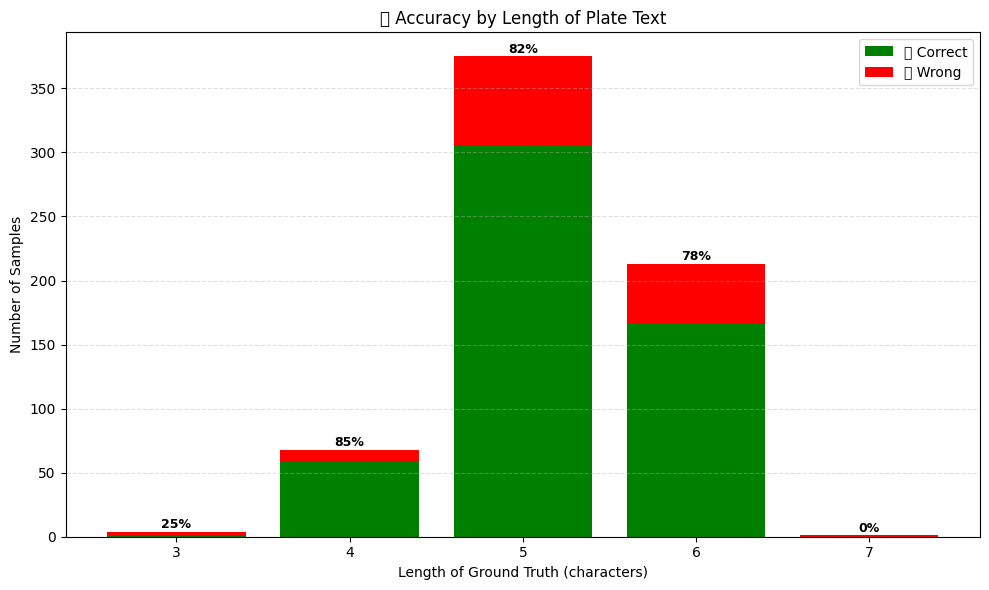


📚 Example Samples per Length:

--- Length 3 ---
✅ Correct Examples:
  GT: 871 | Pred: 871 | Score: 1.00
❌ Wrong Examples:
  GT: 77- | Pred: 77 | Score: 1.00
  GT: 59- | Pred: 59 | Score: 0.98

--- Length 4 ---
✅ Correct Examples:
  GT: 0200 | Pred: 0200 | Score: 1.00
  GT: 3397 | Pred: 3397 | Score: 1.00
❌ Wrong Examples:
  GT: 3S22 | Pred: 3522 | Score: 1.00
  GT: 7181 | Pred: 7184 | Score: 1.00

--- Length 5 ---
✅ Correct Examples:
  GT: 77-AA | Pred: 77-AA | Score: 1.00
  GT: 77-L2 | Pred: 77-L2 | Score: 1.00
❌ Wrong Examples:
  GT: 77-S9 | Pred: 77-S8 | Score: 1.00
  GT: 86131 | Pred: 861.31 | Score: 0.91

--- Length 6 ---
✅ Correct Examples:
  GT: 205.25 | Pred: 205.25 | Score: 1.00
  GT: 376.07 | Pred: 376.07 | Score: 1.00
❌ Wrong Examples:
  GT: 193.82 | Pred: 193.87 | Score: 1.00
  GT: 474.88 | Pred: 47488 | Score: 1.00

--- Length 7 ---
❌ Wrong Examples:
  GT: 357.333 | Pred: 857.33 | Score: 0.87


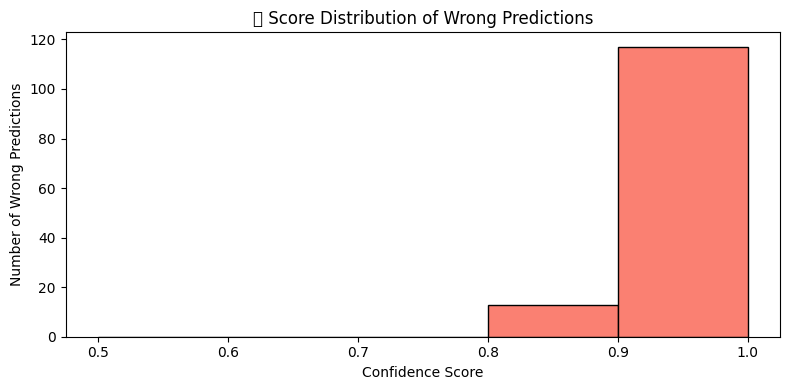


🔠 Top character-level mistakes:
GT: '' → Pred: '.' | 31 lần
GT: '.' → Pred: '' | 11 lần
GT: '5' → Pred: '6' | 6 lần
GT: '6' → Pred: '4' | 6 lần
GT: '2' → Pred: '7' | 3 lần
GT: '8' → Pred: '0' | 3 lần
GT: '6' → Pred: '5' | 3 lần
GT: '4' → Pred: '6' | 3 lần
GT: '9' → Pred: '5' | 3 lần
GT: '7' → Pred: '2' | 3 lần

🚨 Top 5 ký tự có TỶ LỆ DỰ ĐOÁN SAI cao nhất (tối thiểu 5 lần xuất hiện):

🔤 Ký tự: 'B' | Error rate: 36.4% (4/11)
❌ Sai:
  [img: crop_plate_2154_0.jpg]  GT: '71-B2' | Pred: '71-82' → Sai tại vị trí 3: 'B' ≠ '8'
  [img: crop_plate_CAM019_20250326_1631_None_21_0_0.jpg]  GT: '47-B2' | Pred: '47-Y2' → Sai tại vị trí 3: 'B' ≠ 'Y'
  [img: crop_plate_1150_0.jpg]  GT: '77-B3' | Pred: '77-H3' → Sai tại vị trí 3: 'B' ≠ 'H'
✅ Đúng:
  [img: HR156_images_0.jpg]  GT = Pred = '63-B9' (vị trí 3 đúng ký tự 'B')
  [img: HR30_images_0.jpg]  GT = Pred = '60-B8' (vị trí 3 đúng ký tự 'B')
  [img: HR246_images_0.jpg]  GT = Pred = '70-B1' (vị trí 3 đúng ký tự 'B')
-------------------------------------

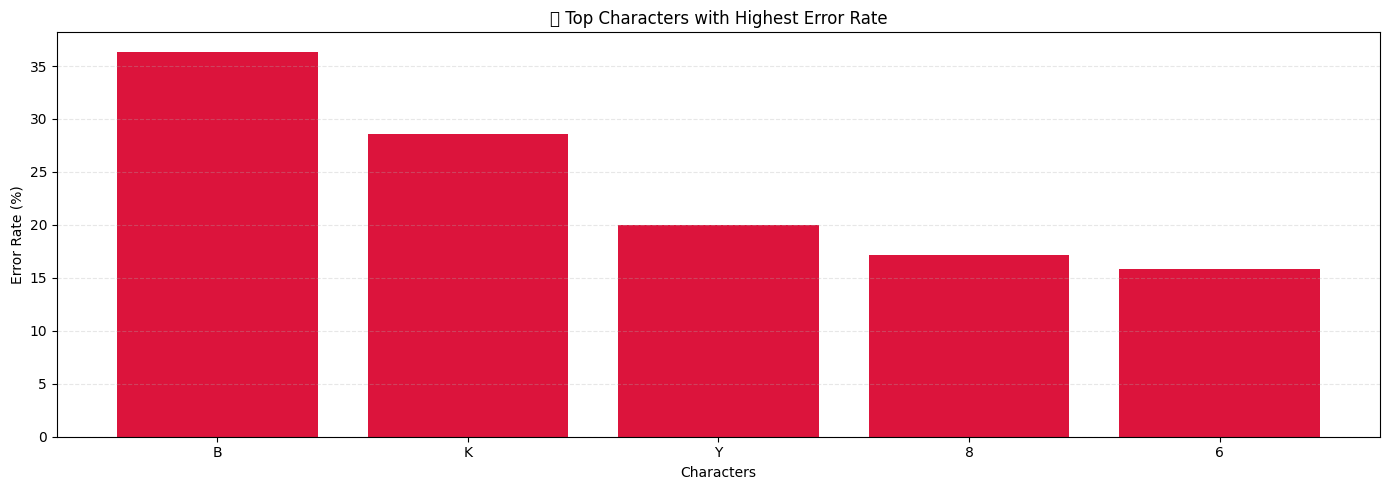


 Top 10 ký tự bị đoán sai nhiều nhất:
  '8': 30 lần bị sai
  '6': 26 lần bị sai
  '2': 21 lần bị sai
  '5': 18 lần bị sai
  '9': 17 lần bị sai
  '1': 17 lần bị sai
  '3': 16 lần bị sai
  '7': 15 lần bị sai
  '4': 15 lần bị sai
  '.': 14 lần bị sai


In [ ]:
analyze_by_length(correct_cases, wrong_cases)
analyze_by_score(wrong_cases)
analyze_char_level_mistakes(wrong_cases)
analyze_char_error_rate_with_examples(correct_cases, wrong_cases, top_k=5, examples_per_char=3)
print_most_misrecognized_characters(correct_cases, wrong_cases, top_k=10)




In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import string

def normalize_text(text):
    """Chuẩn hóa: chữ thường + bỏ dấu câu, giữ lại chữ + số."""
    allowed_chars = string.ascii_lowercase + string.digits
    return ''.join(c.lower() for c in str(text) if c.lower() in allowed_chars)

def analyze_char_error_rate_with_examples(correct_cases, wrong_cases, top_k=5, min_count=5, max_examples_per_char=10):
    char_stats = defaultdict(lambda: {
        "wrong": 0,
        "total": 0,
        "wrong_examples": [],
    })

    all_cases = correct_cases + wrong_cases

    for img_name, gt_raw, pred_raw, score in all_cases:
        gt = normalize_text(gt_raw)
        pred = normalize_text(pred_raw)

        min_len = min(len(gt), len(pred))
        for i in range(min_len):
            c = gt[i]
            char_stats[c]["total"] += 1
            if gt[i] != pred[i]:
                char_stats[c]["wrong"] += 1
                char_stats[c]["wrong_examples"].append((img_name, gt_raw, pred_raw, gt[i], pred[i], i))

        for i in range(min_len, len(gt)):
            c = gt[i]
            char_stats[c]["total"] += 1
            char_stats[c]["wrong"] += 1
            char_stats[c]["wrong_examples"].append((img_name, gt_raw, pred_raw, gt[i], '', i))

    # Tính error rate
    char_error_rate = {
        c: v["wrong"] / v["total"]
        for c, v in char_stats.items() if v["total"] >= min_count
    }

    sorted_error = sorted(char_error_rate.items(), key=lambda x: x[1], reverse=True)

    print(f"\n🚨 Top {top_k} ký tự có TỶ LỆ DỰ ĐOÁN SAI cao nhất (tối thiểu {min_count} lần xuất hiện):\n")

    for c, rate in sorted_error[:top_k]:
        stats = char_stats[c]
        print(f"🔤 Ký tự: '{c}' | Error rate: {rate*100:.1f}% ({stats['wrong']}/{stats['total']})")

        # In tối đa max_examples_per_char ví dụ sai
        wrong_ex = stats["wrong_examples"]
        if wrong_ex:
            print(f"❌ {min(max_examples_per_char, len(wrong_ex))} ví dụ sai:")
            for ex in wrong_ex[:max_examples_per_char]:
                img, gt, pred, gt_c, pred_c, pos = ex
                print(f"  [img: {img}]  GT: '{gt}' | Pred: '{pred}' → Sai tại vị trí {pos}: '{gt_c}' ≠ '{pred_c}'")
        print("-" * 60)

    # Vẽ biểu đồ
    chars = [c for c, _ in sorted_error[:top_k]]
    errors = [char_error_rate[c] * 100 for c in chars]

    plt.figure(figsize=(14, 5))
    plt.bar(chars, errors, color='crimson')
    plt.xlabel("Characters")
    plt.ylabel("Error Rate (%)")
    plt.title("🔍 Top Characters with Highest Error Rate")
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()



🚨 Top 5 ký tự có TỶ LỆ DỰ ĐOÁN SAI cao nhất (tối thiểu 5 lần xuất hiện):

🔤 Ký tự: 'b' | Error rate: 36.4% (4/11)
❌ 4 ví dụ sai:
  [img: crop_plate_2154_0.jpg]  GT: '71-B2' | Pred: '71-82' → Sai tại vị trí 2: 'b' ≠ '8'
  [img: crop_plate_1150_0.jpg]  GT: '77-B3' | Pred: '77-H3' → Sai tại vị trí 2: 'b' ≠ 'h'
  [img: crop_plate_CAM013_20250326_1636_None_12_0_0.jpg]  GT: '81-B3' | Pred: '81.83' → Sai tại vị trí 2: 'b' ≠ '8'
  [img: crop_plate_CAM019_20250326_1631_None_21_0_0.jpg]  GT: '47-B2' | Pred: '47-Y2' → Sai tại vị trí 2: 'b' ≠ 'y'
------------------------------------------------------------
🔤 Ký tự: 'y' | Error rate: 20.0% (2/10)
❌ 2 ví dụ sai:
  [img: HR21_images_0.jpg]  GT: '63-Y1' | Pred: '63-V1' → Sai tại vị trí 2: 'y' ≠ 'v'
  [img: crop_plate_2484_0.jpg]  GT: '81-Y4' | Pred: '81-75' → Sai tại vị trí 2: 'y' ≠ '7'
------------------------------------------------------------
🔤 Ký tự: 'm' | Error rate: 14.3% (1/7)
❌ 1 ví dụ sai:
  [img: crop_plate_1973_0.jpg]  GT: '28-M1' | Pred:

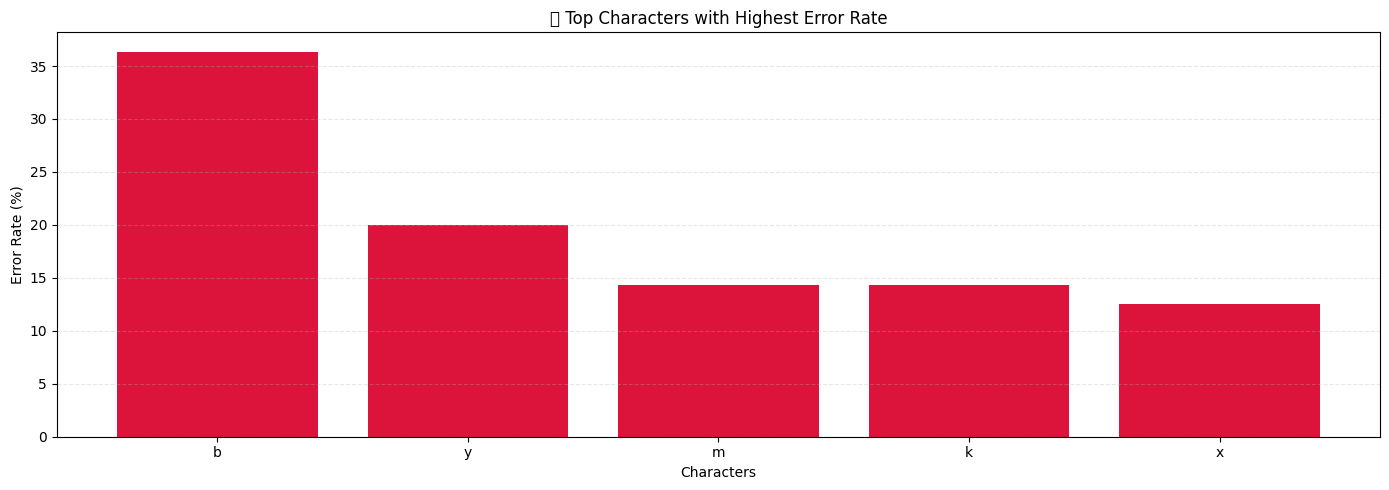

In [ ]:
# Mỗi phần tử gồm: (img_name, gt, pred, score)
analyze_char_error_rate_with_examples(correct_cases, wrong_cases, top_k=5)
